# LCA Slovenská klíma 2022

## Imports and functions

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [97]:
!pip install yattag

  Using cached yattag-1.14.0.tar.gz (26 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for yattag: filename=yattag-1.14.0-py3-none-any.whl size=15659 sha256=37079886d58ef7dd7bae4d74ece37a03ef654bfa135adb85a4a6cdda73cc60e6
  Stored in directory: /home/thomas/.cache/pip/wheels/5d/01/18/024dc78aea85589909f425839a2f10866598ccc2fbd96fb4bd
Successfully built yattag


In [2]:
from yattag import Doc, indent
from datetime import datetime
import unicodedata

def slugify(value, allow_unicode=False):
    """
    Convert to ASCII if 'allow_unicode' is False. Convert spaces to hyphens.
    Remove characters that aren't alphanumerics, underscores, or hyphens.
    Convert to lowercase. Also strip leading and trailing whitespace.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value).strip().lower()
    return re.sub(r'[-\s]+', '-', value)


def create_stamped_temp(dir=None):
    stamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    if dir is None:
        path = '{}/{}'.format(os.environ['TEMP'], stamp)
    else:
        path = '{}/{}/{}'.format(os.environ['TEMP'], dir, stamp)
    os.makedirs(path, exist_ok=True)
    return path


class Chart:

    def __init__(self, figs, cols=3, title=None, format='png'):
        if not isinstance(figs, list):
            figs = [figs]
        self.figs = [f if isinstance(f, plt.Figure) else f.get_figure() for f in figs]
        self.cols = cols
        self.format = format
        self.title = title or self.figs[0].axes[0].title._text

    def save(self, path, inner=False):
        os.makedirs(path, exist_ok=True)
        n = len(self.figs)
        for i in range(n):
            self.figs[i].savefig(f'{path}/fig_{i+1:03d}.{self.format}')
        plt.close('all')

        doc, tag, text = Doc().tagtext()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Chart')
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Chart')
                num_rows = (n + self.cols - 1) // self.cols
                for r in range(num_rows):
                    with tag('div'):
                        for c in range(min(self.cols, n - self.cols * r)):
                            doc.stag('img', src=f'fig_{self.cols * r + c + 1:03d}.{self.format}')

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


class Text:

    def __init__(self, texts, width=750, title=None):
        if not isinstance(texts, list):
            texts = [texts]
        self.texts = texts
        self.width = width
        self.title = title

    def save(self, path, inner=False):
        os.makedirs(path, exist_ok=True)

        doc, tag, text = Doc().tagtext()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Text')
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Text')
                with tag('div'):
                    for t in self.texts:
                        with tag('div', style='width: {}px; float: left'.format(self.width)):
                            with tag('pre'):
                                text(t)

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


class Selector:

    def __init__(self, charts, title=None):
        if not isinstance(charts, list):
            charts = [charts]
        self.charts = [ch if isinstance(ch, (Text, Chart, Selector)) else Chart(ch) for ch in charts]
        self.title = title or 'Selector'

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        n = len(self.charts)
        for i in range(n):
            ch = self.charts[i]
            if ch.title is None:
                ch.title = '{}_{:02d}'.format('Chart' if isinstance(ch, Chart) else ('Text' if isinstance(ch, Text)
                    else 'Selector'), i)
            ch.save('{}/{}'.format(path, slugify(ch.title)))

        doc, tag, text, line = Doc().ttl()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Selector')
                with tag('script'):
                    doc.asis("""
      function loader(target, file) {
        var element = document.getElementById(target);
        var xmlhttp = new XMLHttpRequest();
        xmlhttp.onreadystatechange = function(){
          if(xmlhttp.status == 200 && xmlhttp.readyState == 4){          
            var txt = xmlhttp.responseText;
            var next_file = ""
            var matches = txt.match(/<script>loader\\('.*', '(.*)'\\)<\\/script>/);
            if (matches) {
              next_file = matches[1];
            };            
            txt = txt.replace(/^[\s\S]*<body>/, "").replace(/<\/body>[\s\S]*$/, "");
            txt = txt.replace(/src=\\"fig_/g, "src=\\"" + file + "/fig_");
            txt = txt.replace(/loader\\('/g, "loader('" + file.replace(/\\//g, "-") + "-");
            txt = txt.replace(/div id=\\"/, "div id=\\"" + file.replace(/\\//g, "-") + "-");
            txt = txt.replace(/content', '/g, "content', '" + file + "/");
            element.innerHTML = txt;
            if (next_file) {
              loader(file.replace(/\\//g, "-") + "-content", file + "/" + next_file);
            };            
          };
        };
        xmlhttp.open("GET", file + "/page.htm", true);
        xmlhttp.send();
      }
    """)
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Selector')
                with tag('div'):
                    for ch in self.charts:
                        #line('a', ch.title, href='{}/page.html'.format(slugify(ch.title)), target='iframe')
                        line('button', ch.title, type='button',
                             onclick='loader(\'content\', \'{}\')'.format(slugify(ch.title)))
                with tag('div', id='content'):
                    text('')
                with tag('script'):
                    doc.asis('loader(\'content\', \'{}\')'.format(slugify(self.charts[0].title)))

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


In [3]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [4]:
from datetime import datetime

def logger(msg):
    print('{} -- {}'.format(datetime.now().strftime('%H:%M:%S.%f')[:10], msg))

## Stata data loading

In [5]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/jan-krajhanzl"

// load data
import spss ${PATHD}/slovenska-klima-2022/Data_1.5.sav, clear

In [6]:
%%stata -qui

global contvars "EMO_distres CIMP_scale PIMP_scale AC3_scale ACT_scale BEH_civ SACR_scale POL_hard POL_soft"

global ordvars = "T_MEDT_23 T_ATT_4"

global contordvars = "$contvars $ordvars"

// imputation and standardization
// do not want to go down multiple imputation route... maybe next time.
foreach x in $contordvars {
	reg `x' $demovars [w=vaha]
	predict `x'_pred, xb
	gen `x'_imp = `x'
	replace `x'_imp = `x'_pred if missing(`x'_imp)
	sum `x'_imp [w=vaha]
	gen `x'_std = (`x'_imp - r(mean)) / r(sd)	
}

gen BELIEF_imp = BELIEF
replace BELIEF_imp = 4 if missing(BELIEF_imp)

In [7]:
%%stata -qui
// replace "space" by "_1 space"
local foo : subinstr global contordvars " " "_imp ", all
// add _1 for the final element
global contordimps = "`foo'_imp"

// replace "space" by "_1 space"
local foo : subinstr global contordvars " " "_std ", all
// add _1 for the final element
global contordstds = "`foo'_std"

In [8]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [9]:
df.shape

(1936, 438)

In [10]:
df.head()

,IDrespondenta,Metoda,Dotazník,Recall_Code,ČAS,Anketár,SEX,AGE,AGE_kat,EDU,...,POL_soft_pred,POL_soft_imp,POL_soft_std,T_MEDT_23_pred,T_MEDT_23_imp,T_MEDT_23_std,T_ATT_4_pred,T_ATT_4_imp,T_ATT_4_std,BELIEF_imp
0,1,2,1,4633d3a749c0be474203653e887c545b,,CAWI,2,19,1,1,...,3.602794,3.571429,-0.043457,3.469245,4.0,0.503109,2.432673,1.0,-1.179164,1.0
1,2,2,1,7572fea7d8d68487cd90fc101ebd0caf,,CAWI,1,20,1,3,...,3.602794,3.666667,0.088497,3.469245,2.0,-1.392714,2.432673,2.0,-0.356112,1.0
2,3,2,1,3e1d2ab36282d944313d8e1a46c2fd25,,CAWI,2,20,1,3,...,3.602794,3.555556,-0.065450,3.469245,4.0,0.503109,2.432673,4.0,1.289991,1.0
3,4,2,1,1dc88308d6ee4b985abe819eeb07744a,,CAWI,2,19,1,3,...,3.602794,3.888889,0.396391,3.469245,5.0,1.451020,2.432673,1.0,-1.179164,1.0
4,5,2,1,09ba54b69c350296329b83379d551489,,CAWI,2,20,1,2,...,3.602794,3.666667,0.088497,3.469245,4.0,0.503109,2.432673,3.0,0.466939,1.0


## Basic data check

Zkontroluj proměnné před imputací, po imputaci a po standardizaci. Zkontroluj také počet missing values.

In [11]:
contvars = ['EMO_distres', 'CIMP_scale', 'PIMP_scale', 'AC3_scale', 'ACT_scale', 'BEH_civ', 'SACR_scale', 'POL_hard', 'POL_soft']

In [ ]:
contvars = ['EMO_distres', 'CIMP_scale', 'PIMP_scale', 'AC3_scale', 'ACT_scale', 'BEH_civ', 'SACR_scale', 'POL_hard', 'POL_soft']
ordvars = ['T_MEDT_23', 'T_ATT_4']
noncontvars = ordvars + ['BELIEF']

# RAW
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    sns.histplot(data=df, x=contvars[i], weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=contvars[i])
    # ax[i % 3][i // 3].set_title(contvars[i])
    
for i in range(3):
    x = noncontvars[i]
    foo = df.groupby(x)['vaha'].sum().reset_index()
    sns.barplot(data=foo, x=x, y='vaha', ax=ax[4][i])

desc_raw = Chart(fig, title='Raw')

# IMPUTED
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    x = contvars[i] + '_imp'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])
    
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_imp', weights='vaha', ax=ax[4][i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[4][2])

desc_imp = Chart(fig, title='Imputed')

# STANDARDIZED
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    x = contvars[i] + '_std'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])
    
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_std', weights='vaha', ax=ax[4][i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[4][2])

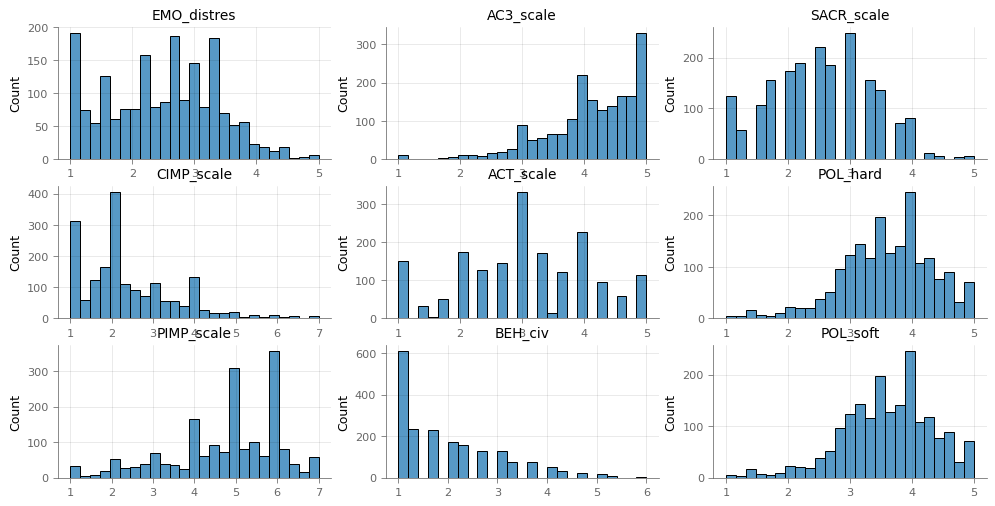

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

for i in range(9):
    sns.histplot(data=df, x=contvars[i], weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=contvars[i])
    # ax[i % 3][i // 3].set_title(contvars[i])

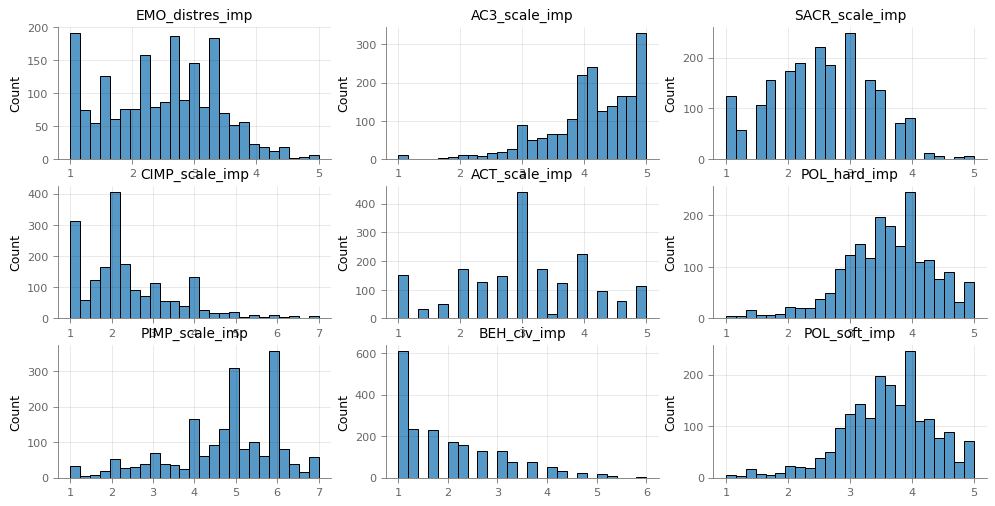

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

for i in range(9):
    x = contvars[i] + '_imp'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])

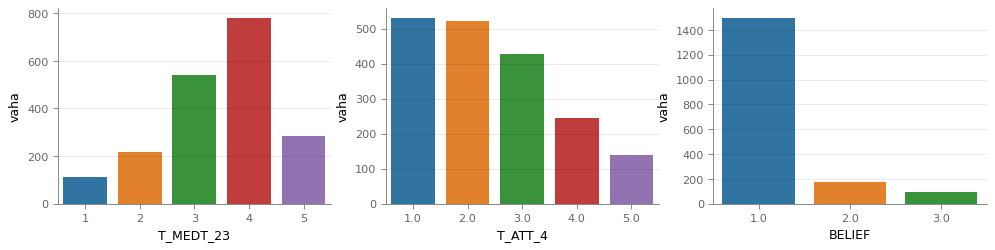

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2.6))
ordvars = ['T_MEDT_23', 'T_ATT_4']
noncontvars = ordvars + ['BELIEF']

for i in range(3):
    x = noncontvars[i]
    foo = df.groupby(x)['vaha'].sum().reset_index()
    sns.barplot(data=foo, x=x, y='vaha', ax=ax[i])

<AxesSubplot:xlabel='BELIEF_imp', ylabel='vaha'>

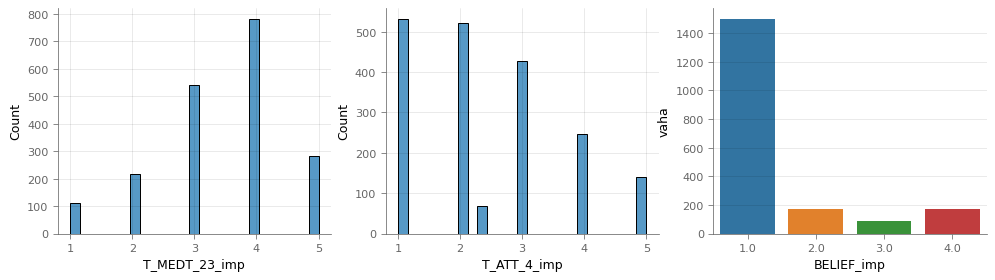

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_imp', weights='vaha', ax=ax[i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[2])

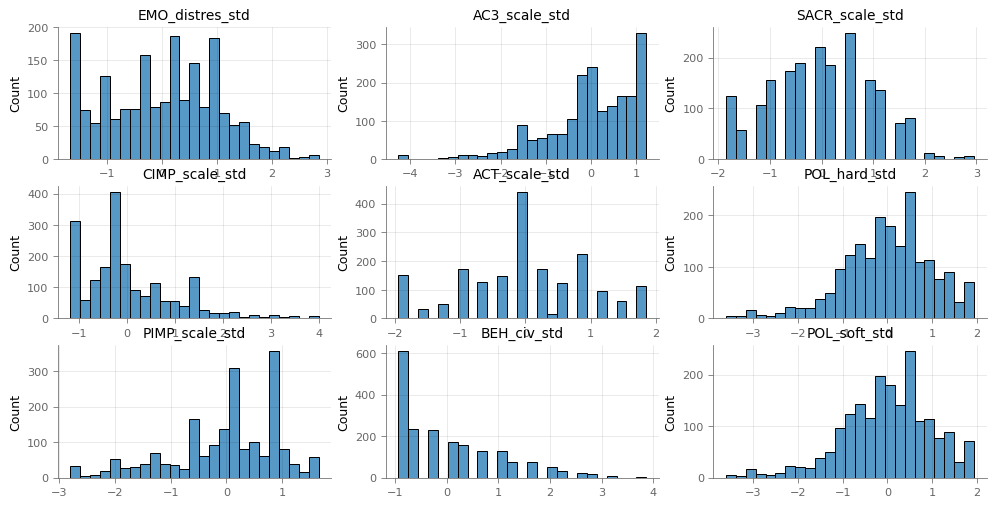

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

for i in range(9):
    x = contvars[i] + '_std'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])

<AxesSubplot:xlabel='BELIEF_imp', ylabel='vaha'>

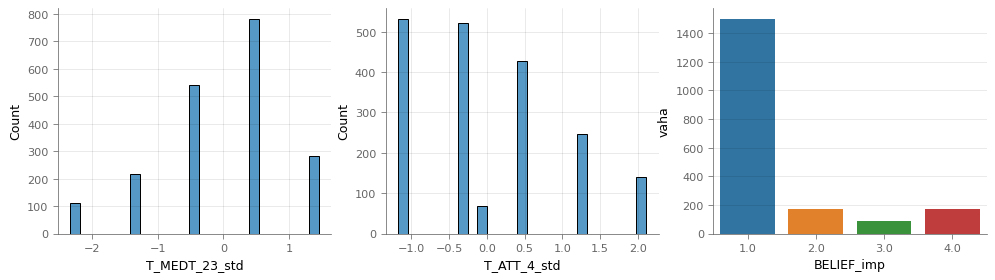

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_std', weights='vaha', ax=ax[i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[2])

In [18]:
pd.isna(df[contvars + noncontvars]).sum(axis=0)

EMO_distres      0
CIMP_scale      59
PIMP_scale      64
AC3_scale       76
ACT_scale      106
BEH_civ          0
SACR_scale       0
POL_hard        52
POL_soft        52
T_MEDT_23        0
T_ATT_4         66
BELIEF         162
dtype: int64

In [19]:
pd.isna(df[contvars + noncontvars]).any(axis=1).sum()

343

In [20]:
pd.isna(df[[x + '_imp' for x in contvars + noncontvars]]).sum(axis=0)

EMO_distres_imp    0
CIMP_scale_imp     0
PIMP_scale_imp     0
AC3_scale_imp      0
ACT_scale_imp      0
BEH_civ_imp        0
SACR_scale_imp     0
POL_hard_imp       0
POL_soft_imp       0
T_MEDT_23_imp      0
T_ATT_4_imp        0
BELIEF_imp         0
dtype: int64

## LCA fitting

In [32]:
plt.rcParams['figure.subplot.top'] = 0.92

In [34]:
def plot_lca(res, variables):
    sel = []
    
    foo = pd.DataFrame({'n': res['LL'].keys(), 'll': res['LL'].values(), 'aic': res['AIC'].values(), 'bic': res['BIC'].values()})

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    for i, x in enumerate(['ll', 'aic', 'bic']):
        sns.barplot(data=foo, x='n', y=x, ax=ax[i])
    sel.append(Chart(fig, title='Criteria'))

    nvars = len(variables)
    
    for n in range(2, 10):

        nrows = (n - 1) // 2 + 1
        fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
        means = res['mean'][n][0]
        probs = res['prob'][n][0]

        for i in range(n):
            cur_means = means[i * nvars:(i + 1) * nvars]
            title = f'Cluster {i + 1} ({100 * probs[i]:.2f} %)'
            if n > 2:
                sns.barplot(x=cur_means, y=variables, ax=ax[i // 2, i % 2])
                ax[i // 2, i % 2].set_title(title)
            else:
                sns.barplot(x=cur_means, y=variables, ax=ax[i])
                ax[i].set_title(title)

        sel.append(Chart(fig, title=f'{n} clusters'))
        
    return sel

In [23]:
full_vars = ['BELIEF'] + contvars + ordvars
cont_vars = contvars + ordvars

In [54]:
%%time
full_res = {}
lls = {}
aics = {}
bics = {}
means = {}
probs = {}

for n in range(2, 10):
    logger(f'Fitting {n} clusters.')
    stata.run(f'gsem ($contordstds <- _cons) (BELIEF_imp <-, logit) [pw=vaha], lclass(C {n})', quietly=True)
    er = stata.get_ereturn()
    lls[n] = er['e(ll)']
    stata.run('estat lcgof', quietly=True)
    rr = stata.get_return()
    aics[n] = rr['r(aic)']
    bics[n] = rr['r(bic)']
    stata.run('estat lcmean, nose', quietly=True)
    rr = stata.get_return()
    means[n] = rr['r(b)']
    stata.run('estat lcprob, nose', quietly=True)
    rr = stata.get_return()
    probs[n] = rr['r(b)']        
    logger(f'{n} clusters: LL = {lls[n]:.1f}, AIC = {aics[n]:.1f}, BIC = {bics[n]:.1f}')
    
logger('Finished.')

full_res['LL'] = lls
full_res['AIC'] = aics
full_res['BIC'] = bics
full_res['mean'] = means
full_res['prob'] = probs

13:14:46.9 -- Fitting 2 clusters.
13:14:53.9 -- 2 clusters: LL = -28415.5, AIC = 56893.0, BIC = 57065.6
13:14:53.9 -- Fitting 3 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:16:46.4 -- 3 clusters: LL = -27609.0, AIC = 55303.9, BIC = 55543.4
13:16:46.4 -- Fitting 4 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:19:57.4 -- 4 clusters: LL = -27010.7, AIC = 54129.5, BIC = 54430.1
13:19:57.4 -- Fitting 5 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:26:28.3 -- 5 clusters: LL = -26598.4, AIC = 53326.9, BIC = 53688.8
13:26:28.3 -- Fitting 6 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:33:10.2 -- 6 clusters: LL = -26449.0, AIC = 53050.0, BIC = 53473.2
13:33:10.2 -- Fitting 7 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:42:37.1 -- 7 clusters: LL = -26315.4, AIC = 52804.9, BIC = 53289.3
13:42:37.1 -- Fitting 8 clusters.
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: convergence not achieved
r(430);



13:56:36.0 -- 8 clusters: LL = -26007.4, AIC = 52210.9, BIC = 52756.6
13:56:36.0 -- Fitting 9 clusters.
convergence not achieved
convergence not achieved


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 169, in run
    raise SystemError(output)
SystemError: r(430);



14:16:27.5 -- 9 clusters: LL = -25847.3, AIC = 51912.5, BIC = 52519.5
14:16:27.6 -- Finished.
CPU times: user 42min, sys: 11min 48s, total: 53min 48s
Wall time: 1h 1min 40s


In [21]:
%%time
cont_res = {}
lls = {}
aics = {}
bics = {}
means = {}
probs = {}

for n in range(2, 10):
    logger(f'Fitting {n} clusters.')
    stata.run(f'gsem ($contordstds <- _cons) [pw=vaha], lclass(C {n})', quietly=True)
    er = stata.get_ereturn()
    lls[n] = er['e(ll)']
    stata.run('estat lcgof', quietly=True)
    rr = stata.get_return()
    aics[n] = rr['r(aic)']
    bics[n] = rr['r(bic)']
    stata.run('estat lcmean, nose', quietly=True)
    rr = stata.get_return()
    means[n] = rr['r(b)']
    stata.run('estat lcprob, nose', quietly=True)
    rr = stata.get_return()
    probs[n] = rr['r(b)']    
    logger(f'{n} clusters: LL = {lls[n]:.1f}, AIC = {aics[n]:.1f}, BIC = {bics[n]:.1f}')
    
logger('Finished.')

cont_res['LL'] = lls
cont_res['AIC'] = aics
cont_res['BIC'] = bics
cont_res['mean'] = means
cont_res['prob'] = probs

16:53:37.3 -- Fitting 2 clusters.
16:53:47.5 -- 2 clusters: LL = -28415.5, AIC = 56893.0, BIC = 57065.6
16:53:47.5 -- Fitting 3 clusters.
16:54:02.2 -- 3 clusters: LL = -27608.8, AIC = 55301.7, BIC = 55535.5
16:54:02.2 -- Fitting 4 clusters.
16:54:31.9 -- 4 clusters: LL = -27010.7, AIC = 54127.3, BIC = 54422.4
16:54:31.9 -- Fitting 5 clusters.
16:55:16.0 -- 5 clusters: LL = -26598.3, AIC = 53324.7, BIC = 53681.1
16:55:16.0 -- Fitting 6 clusters.
16:56:35.3 -- 6 clusters: LL = -26448.9, AIC = 53047.7, BIC = 53465.3
16:56:35.3 -- Fitting 7 clusters.
16:58:56.9 -- 7 clusters: LL = -26112.8, AIC = 52397.5, BIC = 52876.4
16:58:56.9 -- Fitting 8 clusters.
17:02:32.9 -- 8 clusters: LL = -26133.9, AIC = 52461.8, BIC = 53001.9
17:02:32.9 -- Fitting 9 clusters.
17:07:52.1 -- 9 clusters: LL = -25845.9, AIC = 51907.8, BIC = 52509.2
17:07:52.1 -- Finished.
CPU times: user 10min 34s, sys: 1min 44s, total: 12min 18s
Wall time: 14min 14s


In [36]:
%%time
nonr_res = {}
lls = {}
aics = {}
bics = {}
means = {}
probs = {}

for n in range(2, 10):
    logger(f'Fitting {n} clusters.')
    stata.run(f'gsem ($contordstds <- _cons) (BELIEF_imp <-, logit) [pw=vaha], lclass(C {n}) nonrtolerance', quietly=True)
    er = stata.get_ereturn()
    lls[n] = er['e(ll)']
    stata.run('estat lcgof', quietly=True)
    rr = stata.get_return()
    aics[n] = rr['r(aic)']
    bics[n] = rr['r(bic)']
    stata.run('estat lcmean, nose', quietly=True)
    rr = stata.get_return()
    means[n] = rr['r(b)']
    stata.run('estat lcprob, nose', quietly=True)
    rr = stata.get_return()
    probs[n] = rr['r(b)']
    logger(f'{n} clusters: LL = {lls[n]:.1f}, AIC = {aics[n]:.1f}, BIC = {bics[n]:.1f}')
    
logger('Finished.')

nonr_res['LL'] = lls
nonr_res['AIC'] = aics
nonr_res['BIC'] = bics
nonr_res['mean'] = means
nonr_res['prob'] = probs

17:14:25.3 -- Fitting 2 clusters.
17:14:36.5 -- 2 clusters: LL = -28415.5, AIC = 56893.0, BIC = 57065.6
17:14:36.5 -- Fitting 3 clusters.
17:15:12.7 -- 3 clusters: LL = -27609.0, AIC = 55304.0, BIC = 55543.4
17:15:12.7 -- Fitting 4 clusters.
17:16:12.3 -- 4 clusters: LL = -27010.7, AIC = 54129.5, BIC = 54430.2
17:16:12.3 -- Fitting 5 clusters.
17:18:03.9 -- 5 clusters: LL = -26598.5, AIC = 53326.9, BIC = 53688.9
17:18:03.9 -- Fitting 6 clusters.
17:20:11.4 -- 6 clusters: LL = -26449.0, AIC = 53050.0, BIC = 53473.2
17:20:11.4 -- Fitting 7 clusters.
17:23:35.7 -- 7 clusters: LL = -26315.4, AIC = 52804.9, BIC = 53289.3
17:23:35.7 -- Fitting 8 clusters.
17:36:04.7 -- 8 clusters: LL = -26007.5, AIC = 52211.0, BIC = 52756.7
17:36:04.7 -- Fitting 9 clusters.
17:47:28.0 -- 9 clusters: LL = -25847.3, AIC = 51912.5, BIC = 52519.5
17:47:28.0 -- Finished.
CPU times: user 21min 54s, sys: 5min 31s, total: 27min 26s
Wall time: 33min 2s


In [35]:
sel = Selector(plot_lca(cont_res, cont_vars), title='Continuous only')
sel.save('output/lca/res02')

In [40]:
cont_lca_sel = Selector(plot_lca(cont_res, cont_vars), title='Continuous only')
full_lca_sel = Selector(plot_lca(nonr_res, full_vars), title='Full model')


contvars = ['EMO_distres', 'CIMP_scale', 'PIMP_scale', 'AC3_scale', 'ACT_scale', 'BEH_civ', 'SACR_scale', 'POL_hard', 'POL_soft']
ordvars = ['T_MEDT_23', 'T_ATT_4']
noncontvars = ordvars + ['BELIEF']

missings = pd.isna(df[contvars + noncontvars]).sum(axis=0)

# RAW
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    sns.histplot(data=df, x=contvars[i], weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=f'{contvars[i]} (missing {missings[contvars[i]]})')
    # ax[i % 3][i // 3].set_title(contvars[i])
    
for i in range(3):
    x = noncontvars[i]
    foo = df.groupby(x)['vaha'].sum().reset_index()
    sns.barplot(data=foo, x=x, y='vaha', ax=ax[3][i])
    ax[3][i].set(xlabel='', title=f'{x} (missing {missings[x]})')

desc_raw = Chart(fig, title='Raw')

# IMPUTED
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    x = contvars[i] + '_imp'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])
    
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_imp', weights='vaha', ax=ax[3][i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[3][2])

desc_imp = Chart(fig, title='Imputed')

# STANDARDIZED
fig, ax = plt.subplots(4, 3, figsize=(12, 9))

for i in range(9):
    x = contvars[i] + '_std'
    sns.histplot(data=df, x=x, weights='vaha', ax=ax[i % 3][i // 3], bins=25)
    ax[i % 3][i // 3].set(xlabel='', title=x)
    # ax[i % 3][i // 3].set_title(contvars[i])
    
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i] + '_std', weights='vaha', ax=ax[3][i], bins=25)

foo = df.groupby('BELIEF_imp')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF_imp', y='vaha', ax=ax[3][2])

desc_std = Chart(fig, title='Standardized')

desc_all = Selector([desc_raw, desc_imp, desc_std], title='Variables')
                 
rep = Selector([full_lca_sel, cont_lca_sel, desc_all], title='LCA Slovenská klíma 2022')

rep.save('output/lca/res03')

/tmp/ipykernel_29066/259158875.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(4, 3, figsize=(12, 9))


## Analýza clusterů

- Dokážu napočítat průměry etc. z predicted probabilities?
- A kolik je skutečně osob v jednotlivých clusterech, nikoli pravděpodobností?

In [42]:
stata.run(f'gsem ($contordstds <- _cons) (BELIEF_imp <-, logit) [pw=vaha], lclass(C 6) nonrtolerance')
er = stata.get_ereturn()
ll6 = er['e(ll)']
stata.run('predict c6_*, classposteriorpr')
stata.run('estat lcgof')
rr = stata.get_return()
aic6 = rr['r(aic)']
bic6 = rr['r(bic)']
stata.run('estat lcmean, nose')
rr = stata.get_return()
mean6 = rr['r(b)']
stata.run('estat lcprob, nose')
rr = stata.get_return()
prob6 = rr['r(b)']


Fitting class model:

Iteration 0:   (class) log likelihood = -3464.6995  
Iteration 1:   (class) log likelihood = -3464.5324  
Iteration 2:   (class) log likelihood = -3464.5324  

Fitting outcome model:

Iteration 0:   (outcome) log likelihood = -27083.015  
Iteration 1:   (outcome) log likelihood = -25794.203  (not concave)
Iteration 2:   (outcome) log likelihood = -25793.696  (not concave)
Iteration 3:   (outcome) log likelihood = -25793.686  (not concave)
Iteration 4:   (outcome) log likelihood = -25793.685  (not concave)
Iteration 5:   (outcome) log likelihood = -25793.684  (not concave)
Iteration 6:   (outcome) log likelihood = -25793.684  (not concave)
Iteration 7:   (outcome) log likelihood = -25793.684  (not concave)
Iteration 8:   (outcome) log likelihood = -25793.684  (not concave)

Refining starting values:

Iteration 0:   (EM) log likelihood = -29409.895
Iteration 1:   (EM) log likelihood = -29137.668
Iteration 2:   (EM) log likelihood = -28831.063
Iteration 3:   (EM) lo

In [43]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [44]:
df.shape

(1936, 444)

In [88]:
df.head()

,IDrespondenta,Metoda,Dotazník,Recall_Code,ČAS,Anketár,SEX,AGE,AGE_kat,EDU,...,c6_4,c6_5,c6_6,c6_max,c6_1_w,c6_2_w,c6_3_w,c6_4_w,c6_5_w,c6_6_w
0,1,2,1,4633d3a749c0be474203653e887c545b,,CAWI,2,19,1,1,...,0.990773,0.007373,1.204724e-12,4,0.000000e+00,5.811342e-08,1.960408e-03,1.047680,0.007796,1.273918e-12
1,2,2,1,7572fea7d8d68487cd90fc101ebd0caf,,CAWI,1,20,1,3,...,0.340048,0.097913,1.054648e-11,3,1.412511e-37,6.000503e-07,6.648685e-01,0.402263,0.115826,1.247605e-11
2,3,2,1,3e1d2ab36282d944313d8e1a46c2fd25,,CAWI,2,20,1,3,...,0.535520,0.006463,4.026319e-13,4,2.268714e-34,1.006057e-05,4.197493e-01,0.490788,0.005923,3.690003e-13
3,4,2,1,1dc88308d6ee4b985abe819eeb07744a,,CAWI,2,19,1,3,...,0.140693,0.859247,6.006534e-05,5,0.000000e+00,2.981305e-15,5.764170e-07,0.138319,0.844752,5.905212e-05
4,5,2,1,09ba54b69c350296329b83379d551489,,CAWI,2,20,1,2,...,0.695236,0.079423,1.185416e-10,4,2.022124e-38,2.882170e-07,2.633575e-01,0.812528,0.092822,1.385406e-10


In [46]:
prob6

array([[0.04861336, 0.19501989, 0.17756312, 0.1539276 , 0.28389826,
        0.14097777]])

In [50]:
nanaverage(df[[f'c6_{i}' for i in range(1, 7)] + ['vaha']], weights='vaha')

c6_1    0.048621
c6_2    0.195049
c6_3    0.177533
c6_4    0.153936
c6_5    0.283909
c6_6    0.140952
dtype: float64

In [62]:
df['c6_max'] = np.argmax(df[[f'c6_{i}' for i in range(1, 7)]].values, axis=1) + 1

In [63]:
df['c6_max'].value_counts()

5    559
2    390
3    331
4    287
6    273
1     96
Name: c6_max, dtype: int64

In [64]:
df.groupby('c6_max')['vaha'].sum()

c6_max
1     92.499343
2    387.981094
3    335.100595
4    283.412789
5    562.031134
6    272.674518
Name: vaha, dtype: float64

In [66]:
df.groupby(['c6_max', 'BELIEF_imp'])['vaha'].sum().unstack()

BELIEF_imp,1.0,2.0,3.0,4.0
c6_max,,,,
1,48.902946,13.171681,18.596893,11.827823
2,277.120161,51.087712,23.774509,35.998712
3,217.944709,39.676186,20.965421,56.514279
4,251.078239,10.236509,3.715181,18.382860
5,466.831252,41.275395,16.275858,37.648628
6,237.622754,19.594238,6.435103,9.022423


In [68]:
cont_vars

['EMO_distres',
 'CIMP_scale',
 'PIMP_scale',
 'AC3_scale',
 'ACT_scale',
 'BEH_civ',
 'SACR_scale',
 'POL_hard',
 'POL_soft',
 'T_MEDT_23',
 'T_ATT_4']

In [72]:
for i in range(1, 7):
    df[f'c6_{i}_w'] = df[f'c6_{i}'] * df['vaha']

In [83]:
nanaverage(df[[f'{x}_std' for x in cont_vars] + ['c6_1_w']], weights='c6_1_w')

EMO_distres_std   -0.958931
CIMP_scale_std     0.694052
PIMP_scale_std    -0.764767
AC3_scale_std     -1.719698
ACT_scale_std     -1.101297
BEH_civ_std       -0.568321
SACR_scale_std    -1.228052
POL_hard_std      -2.474572
POL_soft_std      -2.474572
T_MEDT_23_std     -1.006228
T_ATT_4_std        1.176259
dtype: float64

In [85]:
mean6[0][:12]

array([ 1.        , -0.95895274,  0.6940581 , -0.76475985, -1.71970185,
       -1.10129273, -0.56833483, -1.22806152, -2.47460508, -2.47460253,
       -1.00623308,  1.17626784])

In [86]:
nanaverage(df[[f'{x}_std' for x in cont_vars] + ['c6_2_w']], weights='c6_2_w')

EMO_distres_std   -0.241246
CIMP_scale_std     0.226014
PIMP_scale_std    -0.227903
AC3_scale_std     -0.483294
ACT_scale_std     -0.373922
BEH_civ_std       -0.166336
SACR_scale_std    -0.429021
POL_hard_std      -1.031816
POL_soft_std      -1.031816
T_MEDT_23_std     -0.337104
T_ATT_4_std        0.373856
dtype: float64

In [87]:
mean6[0][12:24]

array([ 0.99999805, -0.241196  ,  0.22619638, -0.22785251, -0.48321675,
       -0.37388199, -0.16642533, -0.42895909, -1.03183937, -1.0317285 ,
       -0.33699216,  0.3739163 ])

In [90]:
df.columns

Index(['IDrespondenta', 'Metoda', 'Dotazník', 'Recall_Code', 'ČAS', 'Anketár',
       'SEX', 'AGE', 'AGE_kat', 'EDU',
       ...
       'c6_4', 'c6_5', 'c6_6', 'c6_max', 'c6_1_w', 'c6_2_w', 'c6_3_w',
       'c6_4_w', 'c6_5_w', 'c6_6_w'],
      dtype='object', length=451)

In [79]:
df['c6_1'] * df['vaha']

0       0.000000e+00
1       1.412511e-37
2       2.268714e-34
3       0.000000e+00
4       2.022124e-38
            ...     
1931    2.913532e-07
1932    4.884434e-07
1933    9.457143e-27
1934    1.952538e-21
1935    0.000000e+00
Length: 1936, dtype: float64

In [80]:
df[[f'{x}_std' for x in cont_vars]]

,EMO_distres_std,CIMP_scale_std,PIMP_scale_std,AC3_scale_std,ACT_scale_std,BEH_civ_std,SACR_scale_std,POL_hard_std,POL_soft_std,T_MEDT_23_std,T_ATT_4_std
0,1.858358,-1.178697,0.725443,7.669833e-01,0.903361,-0.625248,-0.352225,-0.043457,-0.043457,0.503109,-1.179164e+00
1,-0.397318,0.112836,0.725443,2.736210e-01,-0.683698,-0.945938,0.249465,0.088497,0.088497,-1.392714,-3.561123e-01
2,1.012480,-0.317675,-0.018417,-1.312189e+00,0.585949,2.581643,0.550311,-0.065450,-0.065450,0.503109,1.289991e+00
3,2.140318,-1.178697,1.469303,1.225106e+00,1.855596,3.223021,0.851156,0.396391,0.396391,1.451020,-1.179164e+00
4,1.012480,-0.532931,-1.692101,-7.835857e-01,0.585949,1.298886,0.550311,0.088497,0.088497,0.503109,4.669395e-01
...,...,...,...,...,...,...,...,...,...,...,...
1931,-0.397318,0.112836,-1.134206,-1.523630e+00,-1.001109,-0.945938,-1.856451,-1.297024,-1.297024,-0.444802,4.669395e-01
1932,-0.256339,1.404369,-0.576311,-8.893060e-01,-1.001109,-0.625248,-1.856451,-1.297024,-1.297024,-1.392714,1.289991e+00
1933,0.871500,0.543347,-0.204381,5.907827e-01,0.268538,0.336819,-0.653070,-0.373344,-0.373344,-0.444802,1.289991e+00
1934,0.871500,-0.317675,0.911408,8.022234e-01,-0.366286,-0.625248,-1.254761,-0.604264,-0.604264,-1.392714,-4.664654e-08


In [82]:
np.average(df[[f'{x}_std' for x in cont_vars]], weights=pd.Series(df['c6_1'] * df['vaha']), axis=1)

ValueError: Length of weights not compatible with specified axis.

In [53]:
mean6

array([[ 1.        , -0.95895274,  0.6940581 , -0.76475985, -1.71970185,
        -1.10129273, -0.56833483, -1.22806152, -2.47460508, -2.47460253,
        -1.00623308,  1.17626784,  0.99999805, -0.241196  ,  0.22619638,
        -0.22785251, -0.48321675, -0.37388199, -0.16642533, -0.42895909,
        -1.03183937, -1.0317285 , -0.33699216,  0.3739163 ,  1.        ,
        -0.3073855 ,  0.45222147, -0.33567303, -0.43810552, -0.3145127 ,
        -0.13992073, -0.38721925, -0.21073077, -0.21074123, -0.50769512,
         0.46955104,  0.99999999,  0.29421451, -0.32369535,  0.21168408,
         0.38847367,  0.26242479,  0.05410101,  0.33857263, -0.1010938 ,
        -0.10109084,  0.42700591, -0.45907021,  0.99991282,  0.09286914,
        -0.23289418,  0.24972176,  0.34548065,  0.19358594,  0.05038922,
         0.20595605,  0.59276788,  0.59276834,  0.20310815, -0.26793697,
         0.99967023,  0.54343067, -0.29888242,  0.26781668,  0.69353403,
         0.61691228,  0.44196516,  0.72040584,  1.4

## Output

TO DO:
- get variable labels
- get the list of variables to process
- compute values (mean, sd, min, max, class means, possibly class differences as in the excel)
- dump it all to excel

In [92]:
_, df_meta = pyreadstat.read_sav('/mnt/d/projects/jan-krajhanzl/slovenska-klima-2022/Data_1.5.sav')

In [171]:
names_to_labels = df_meta.column_names_to_labels

In [101]:
output_cols = list(df_meta.column_names_to_labels.keys())[6:]

In [113]:
# hack to fix messy Stata _vX columns...
df = df.rename(columns={f'_v{i + 1}': c for i, c in enumerate([c for c in output_cols if '.' in c])})

In [142]:
no_output_cols = ['KRAJ', 'PSC', 'vaha_pohlavie', 'vaha_vek', 'vaha_kraj', 'vaha_velob', 'vaha_vzdel', 'vaha_internet', 'vaha_prijem', 'vaha']
output_cols = [c for c in output_cols if c not in no_output_cols]

In [173]:
output_cols = [f'{c}_std' for c in cont_vars] + cont_vars + output_cols
for c in cont_vars:
    names_to_labels[f'{c}_std'] = names_to_labels[c]

KeyError: 'EMO_distres_std'

Descriptives to output:
- mean
- std_dev
- min
- class means
- max

In [145]:
out_var = pd.Series({c: c for c in output_cols})

In [151]:
out_label = pd.Series({c: names_to_labels[c] for c in output_cols})

In [144]:
%%time

nclass = 6

out_mean = pd.Series(dtype='float64')
out_std_dev = pd.Series(dtype='float64')
out_min = pd.Series(dtype='float64')
out_max = pd.Series(dtype='float64')

out_class_means = {}
for i in range(1, nclass + 1):
    out_class_means[i] = pd.Series(dtype='float64')

out_maxclass_means = {}
for i in range(1, nclass + 1):
    out_maxclass_means[i] = pd.Series(dtype='float64')


for c in output_cols:
    foo = df[[c, 'vaha']].dropna(subset=[c])
    dsw = DescrStatsW(foo[c], weights=foo['vaha'])
    out_mean[c] = dsw.mean
    out_std_dev[c] = dsw.std
    out_min[c] = df[c].min()
    out_max[c] = df[c].max()
    
    for i in range(1, nclass + 1):
        out_class_means[i][c] = nanaverage(df[[c, f'c{nclass}_{i}_w']], weights=f'c{nclass}_{i}_w')[0]
        
    foo = df.groupby('c6_max')[[c, 'vaha']].apply(nanaverage, weights='vaha')[c]
    for i in range(1, nclass + 1):
        out_maxclass_means[i][c] = foo[i]

CPU times: user 10.6 s, sys: 15.6 ms, total: 10.6 s
Wall time: 10.7 s


In [152]:
outs = {
    'var': out_var,
    'label': out_label,
    'mean': out_mean,
    'std_dev': out_std_dev,
    'min': out_min,
    **{f'c{i}_mean': out_class_means[i] for i in range(1, nclass + 1)},
    'max': out_max,
    **{f'cmax{i}_mean': out_maxclass_means[i] for i in range(1, nclass + 1)}
}

In [153]:
output = pd.DataFrame(outs)

In [159]:
output.head()

,var,label,mean,std_dev,min,c1_mean,c2_mean,c3_mean,c4_mean,c5_mean,...,cmax1_mean,cmax2_mean,cmax3_mean,cmax4_mean,cmax5_mean,cmax6_mean,c_min,c_max,c_diff,c_pct
SEX,SEX,Pohlavie,1.520118,0.499595,1.0,1.434586,1.485720,1.518929,1.563939,1.555793,...,1.432509,1.481783,1.514366,1.589416,1.549598,1.478660,1.434586,1.563939,0.129353,0.129353
AGE,AGE,Vek,44.157061,17.349900,16.0,44.980852,42.569385,45.376074,40.474640,45.572775,...,44.922341,42.489466,45.537668,39.801365,45.848527,45.614362,40.474640,45.704609,5.229969,0.072638
AGE_kat,AGE_kat,Vek_kat,4.221135,1.884630,1.0,4.280194,4.088986,4.358580,3.832596,4.359331,...,4.272704,4.083843,4.371438,3.754207,4.389196,4.353191,3.832596,4.359331,0.526735,0.087789
EDU,EDU,Vzdelanie,2.481265,0.988463,1.0,2.589407,2.518175,2.398493,2.528163,2.460090,...,2.601954,2.512800,2.395338,2.509198,2.476674,2.481485,2.398493,2.589407,0.190914,0.063638
VMB,VMB,Veľkost miesta bydliska,3.554777,1.632908,1.0,4.014961,3.361008,3.474603,3.506071,3.577925,...,4.025374,3.350728,3.500756,3.502706,3.585514,3.742627,3.361008,4.014961,0.653953,0.130791


In [161]:
output['c_min'] = output[[f'c{i}_mean' for i in range(1, nclass + 1)]].min(axis=1)
output['c_max'] = output[[f'c{i}_mean' for i in range(1, nclass + 1)]].max(axis=1)
output['c_diff'] = output['c_max'] - output['c_min']
output['c_pct'] = output['c_diff'] / (output['max'] - output['min'])
output['c_pct_x100'] = 100 * output['c_pct']

In [170]:
# output.to_csv('output/lca/c6.csv', index=False, encoding='cp1250')
output.to_csv('output/lca/c6.csv', index=False, encoding='utf8')

## Data bug

Proměnné `POL_hard` a `POL_soft` jsou identické.

<AxesSubplot:xlabel='POL_hard', ylabel='POL_soft'>

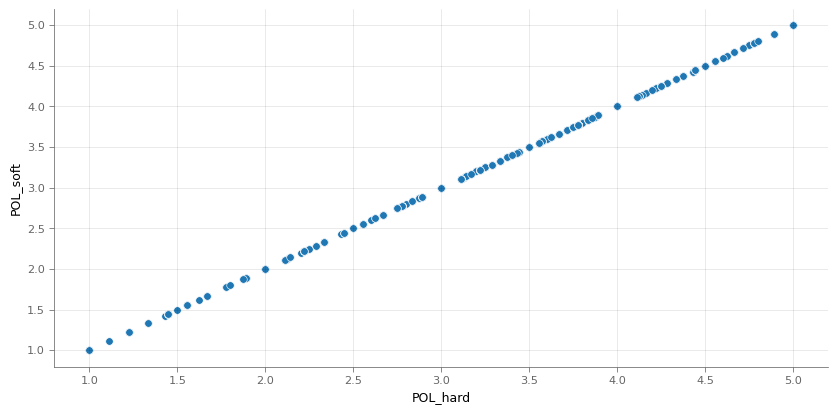

In [41]:
sns.scatterplot(data=df, x='POL_hard', y='POL_soft')

## Miscellaneous

In [64]:
foo = pd.DataFrame({'n': full_res['LL'].keys(), 'll': full_res['LL'].values(), 'aic': full_res['AIC'].values(), 'bic': full_res['BIC'].values()})
foo

,n,ll,aic,bic
0,2,-28415.482744,56892.965488,57065.585246
1,3,-27608.957092,55303.914183,55543.354492
2,4,-27010.726446,54129.452892,54430.145373
3,5,-26598.446647,53326.893294,53688.837947
4,6,-26448.987544,53049.975089,53473.171913
5,7,-26315.427329,52804.854658,53289.303654
6,8,-26007.439915,52210.879831,52756.580999
7,9,-25847.256224,51912.512447,52519.465787


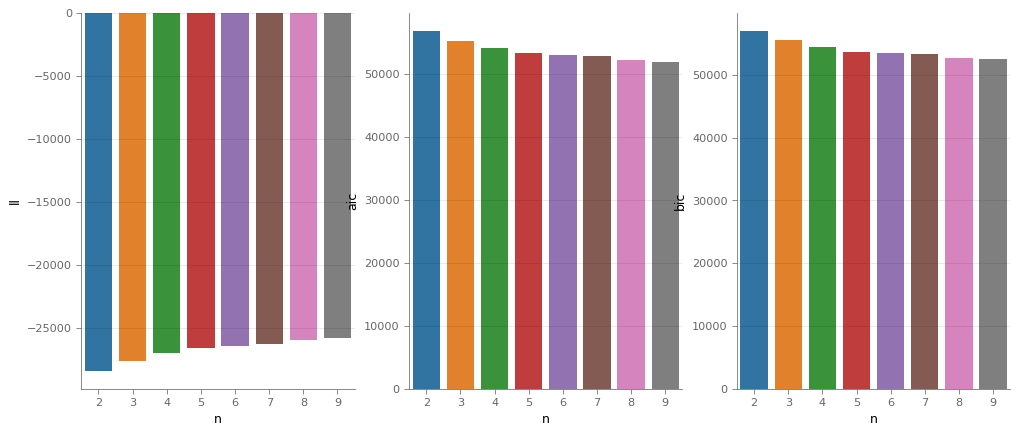

In [65]:
foo = pd.DataFrame({'n': full_res['LL'].keys(), 'll': full_res['LL'].values(), 'aic': full_res['AIC'].values(), 'bic': full_res['BIC'].values()})

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, x in enumerate(['ll', 'aic', 'bic']):
    sns.barplot(data=foo, x='n', y=x, ax=ax[i])

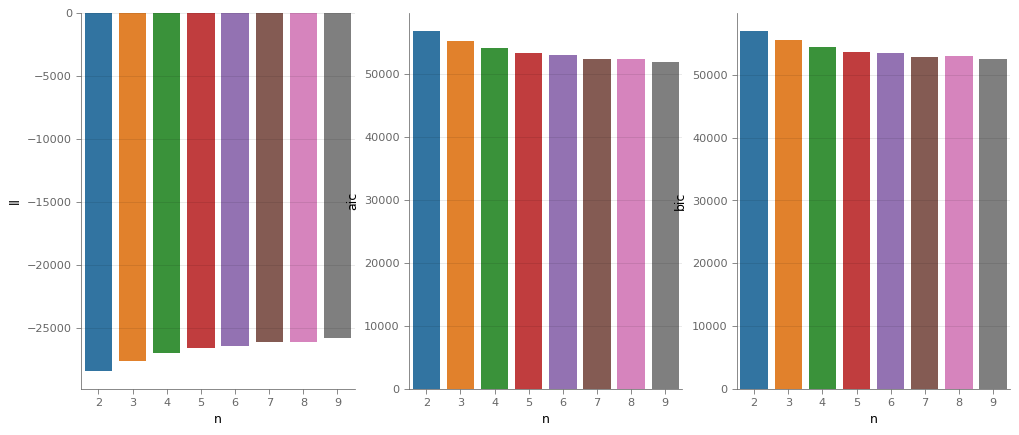

In [66]:
foo = pd.DataFrame({'n': cont_res['LL'].keys(), 'll': cont_res['LL'].values(), 'aic': cont_res['AIC'].values(), 'bic': cont_res['BIC'].values()})

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, x in enumerate(['ll', 'aic', 'bic']):
    sns.barplot(data=foo, x='n', y=x, ax=ax[i])

In [67]:
foo

,n,ll,aic,bic
0,2,-28415.482744,56892.965488,57065.585246
1,3,-27608.837048,55301.674096,55535.546025
2,4,-27010.652659,54127.305317,54422.429418
3,5,-26598.348489,53324.696979,53681.073252
4,6,-26448.858625,53047.717250,53465.345696
5,7,-26112.755536,52397.511073,52876.391690
6,8,-26133.898155,52461.796309,53001.929098
7,9,-25845.914091,51907.828183,52509.213144


In [76]:
full_res['mean'][2][0][0:12]

array([ 1.        , -0.41384964,  0.39325269, -0.38220786, -0.68344693,
       -0.51025455, -0.25377335, -0.59613518, -0.85668831, -0.85668831,
       -0.55873905,  0.56268902])

In [74]:
full_vars = ['BELIEF'] + contvars + ordvars
cont_vars = contvars + ordvars

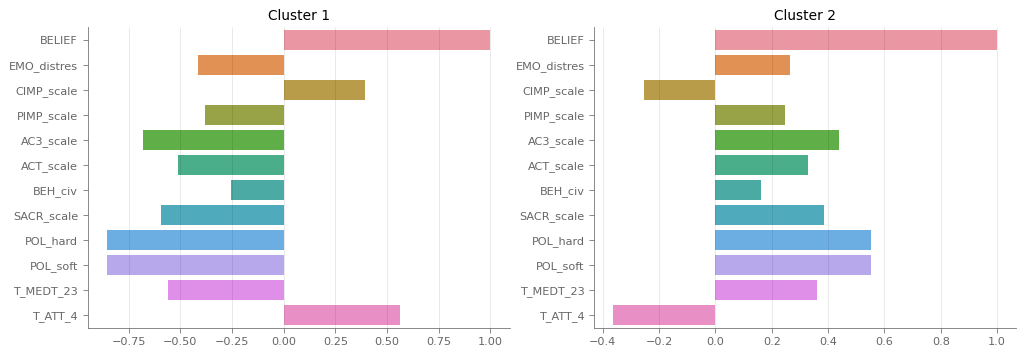

In [89]:
n = 2

nrows = (n - 1) // 2 + 1
fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
means = full_res['mean'][n][0]

for i in range(n):
    cur_means = means[i * 12:(i + 1) * 12]
    if n > 2:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i // 2, i % 2])
        ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
    else:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i])
        ax[i].set_title(f'Cluster {i + 1}')

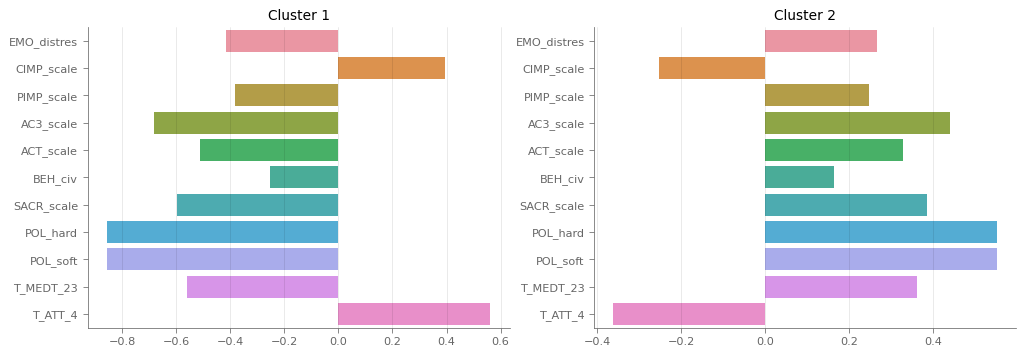

In [95]:
n = 2

nrows = (n - 1) // 2 + 1
fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
means = cont_res['mean'][n][0]

for i in range(n):
    cur_means = means[i * 11:(i + 1) * 11]
    if n > 2:
        sns.barplot(x=cur_means, y=cont_vars, ax=ax[i // 2, i % 2])
        ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
    else:
        sns.barplot(x=cur_means, y=cont_vars, ax=ax[i])
        ax[i].set_title(f'Cluster {i + 1}')

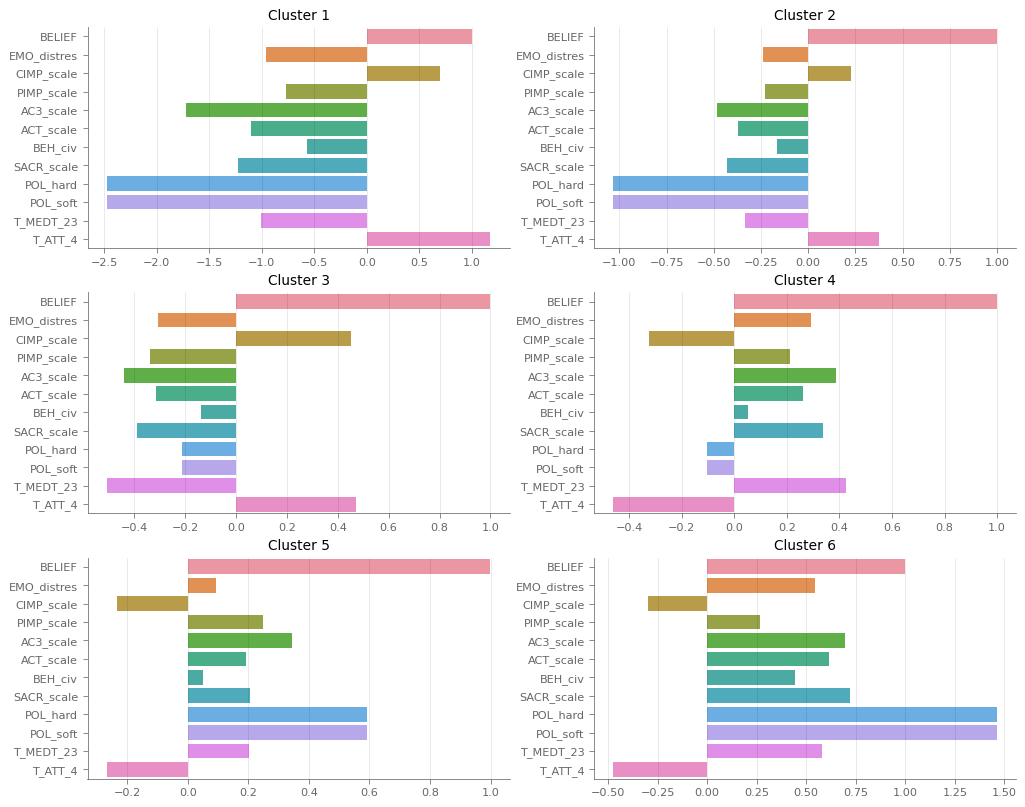

In [91]:
n = 6

nrows = (n - 1) // 2 + 1
fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
means = full_res['mean'][n][0]

for i in range(n):
    cur_means = means[i * 12:(i + 1) * 12]
    if n > 2:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i // 2, i % 2])
        ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
    else:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i])
        ax[i].set_title(f'Cluster {i + 1}')

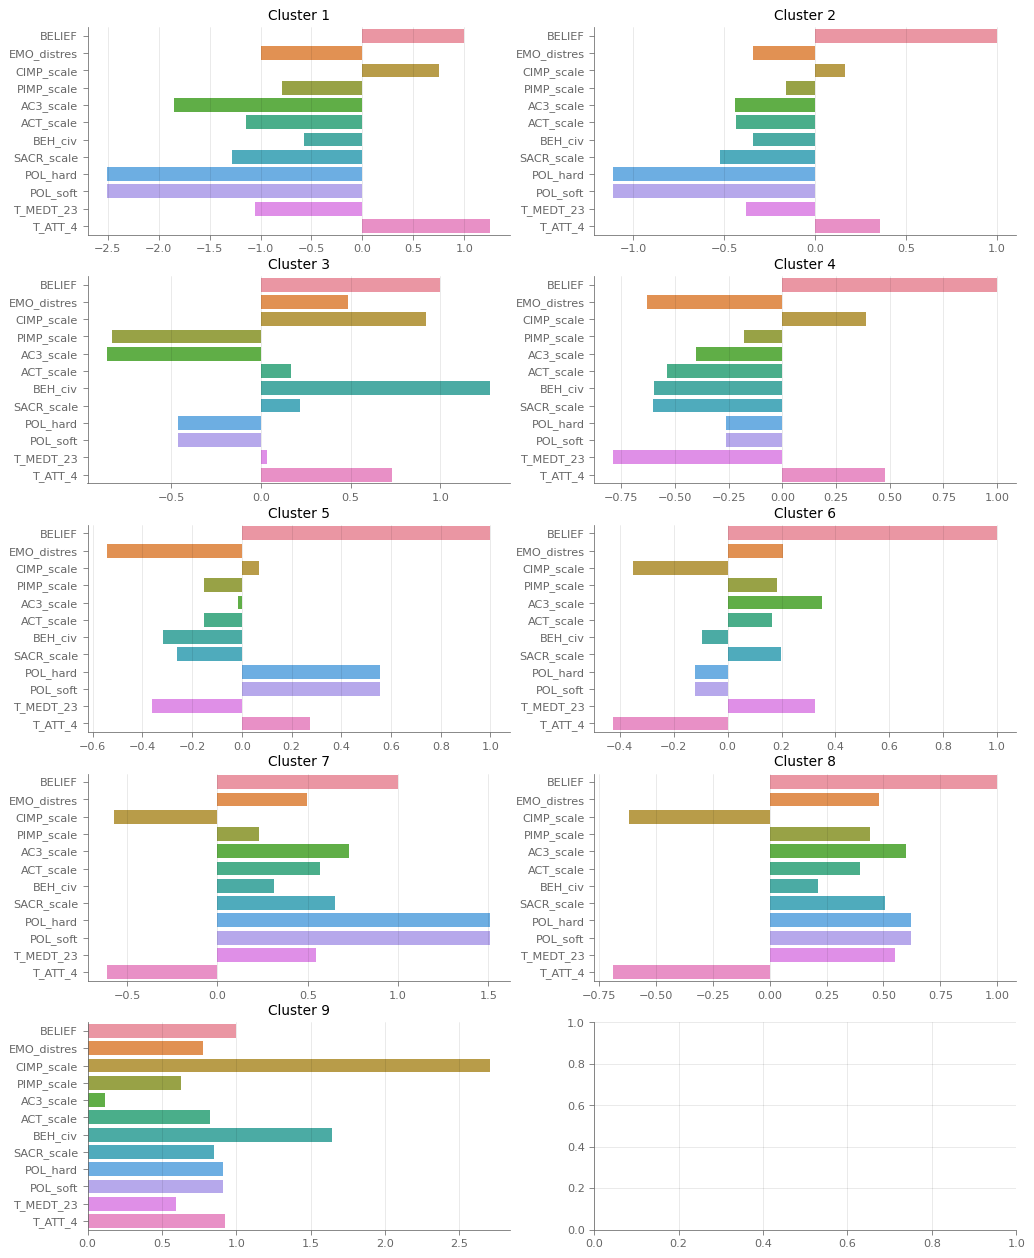

In [92]:
n = 9

nrows = (n - 1) // 2 + 1
fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
means = full_res['mean'][n][0]

for i in range(n):
    cur_means = means[i * 12:(i + 1) * 12]
    if n > 2:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i // 2, i % 2])
        ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
    else:
        sns.barplot(x=cur_means, y=full_vars, ax=ax[i])
        ax[i].set_title(f'Cluster {i + 1}')

In [ ]:
def plot_lca(res, variables):
    sel = []
    
    foo = pd.DataFrame({'n': res['LL'].keys(), 'll': res['LL'].values(), 'aic': res['AIC'].values(), 'bic': res['BIC'].values()})

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    for i, x in enumerate(['ll', 'aic', 'bic']):
        sns.barplot(data=foo, x='n', y=x, ax=ax[i])
    sel.append(Chart(fig, title='Criteria'))

    nvars = len(variables)
    
    for n in range(2, 10):

        print(i)
        nrows = (n - 1) // 2 + 1
        fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
        means = res['mean'][n][0]
        probs = res['prob'][n][0]

        for i in range(n):
            cur_means = means[i * nvars:(i + 1) * nvars]
            title = f'Cluster {i + 1} ({100 * probs[i]:.2f} %)'
            if n > 2:
                sns.barplot(x=cur_means, y=variables, ax=ax[i // 2, i % 2])
                ax[i // 2, i % 2].set_title(title)
            else:
                sns.barplot(x=cur_means, y=variables, ax=ax[i])
                ax[i].set_title(title)

        sel.append(Chart(fig, title=f'{n} clusters'))
        
    return sel

2
1
2
3
4
5
6
7


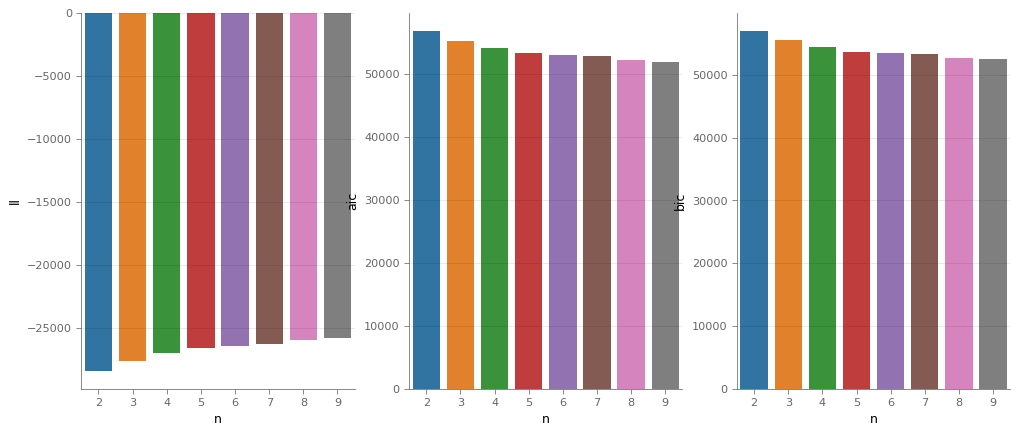

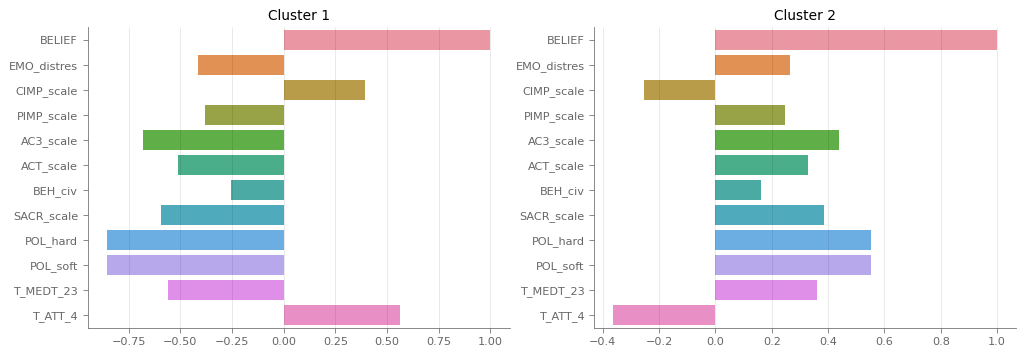

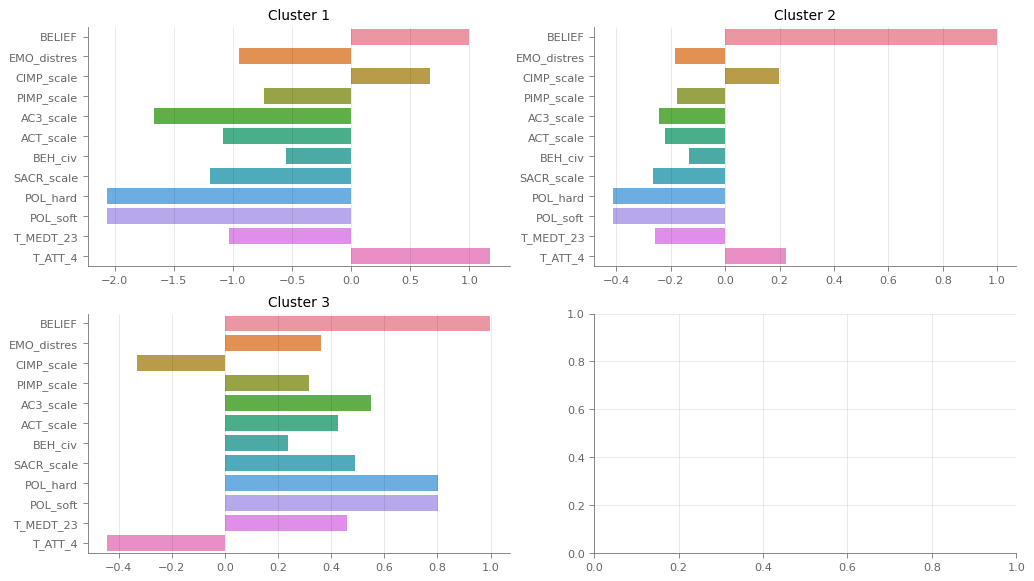

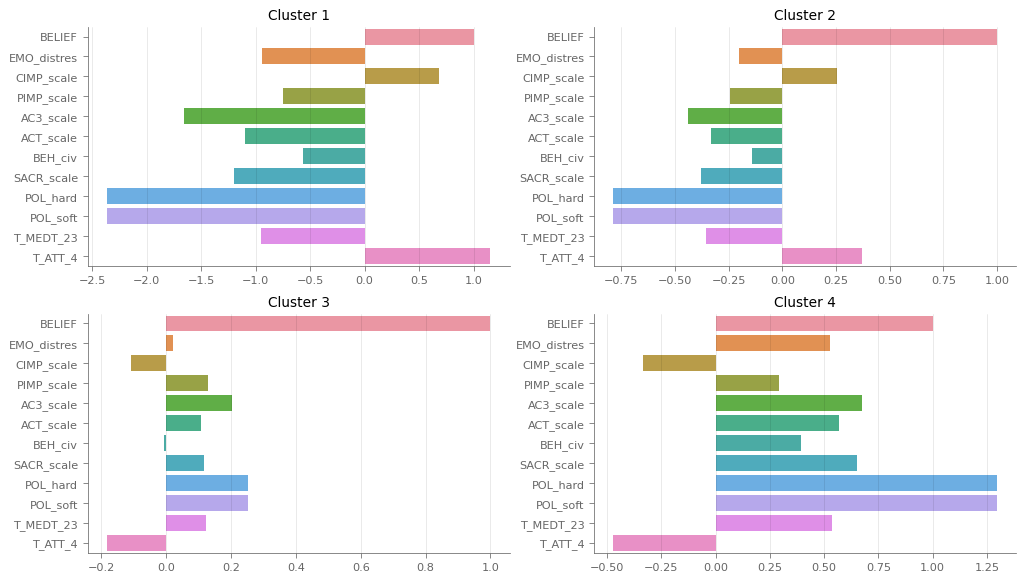

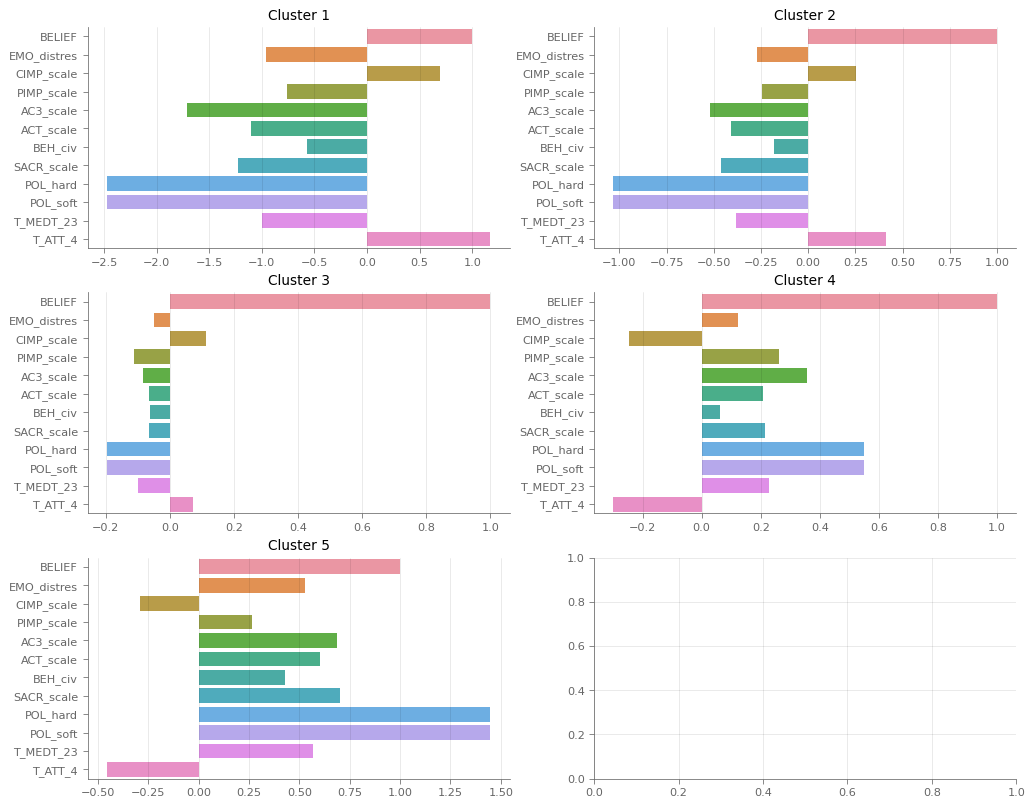

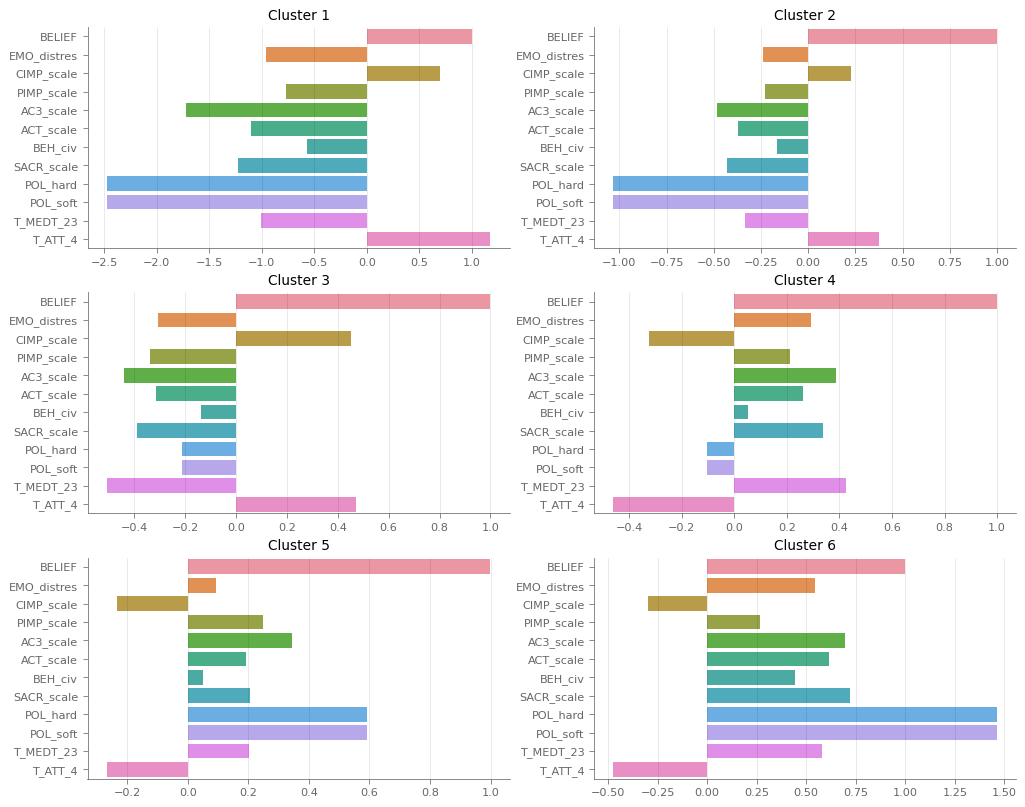

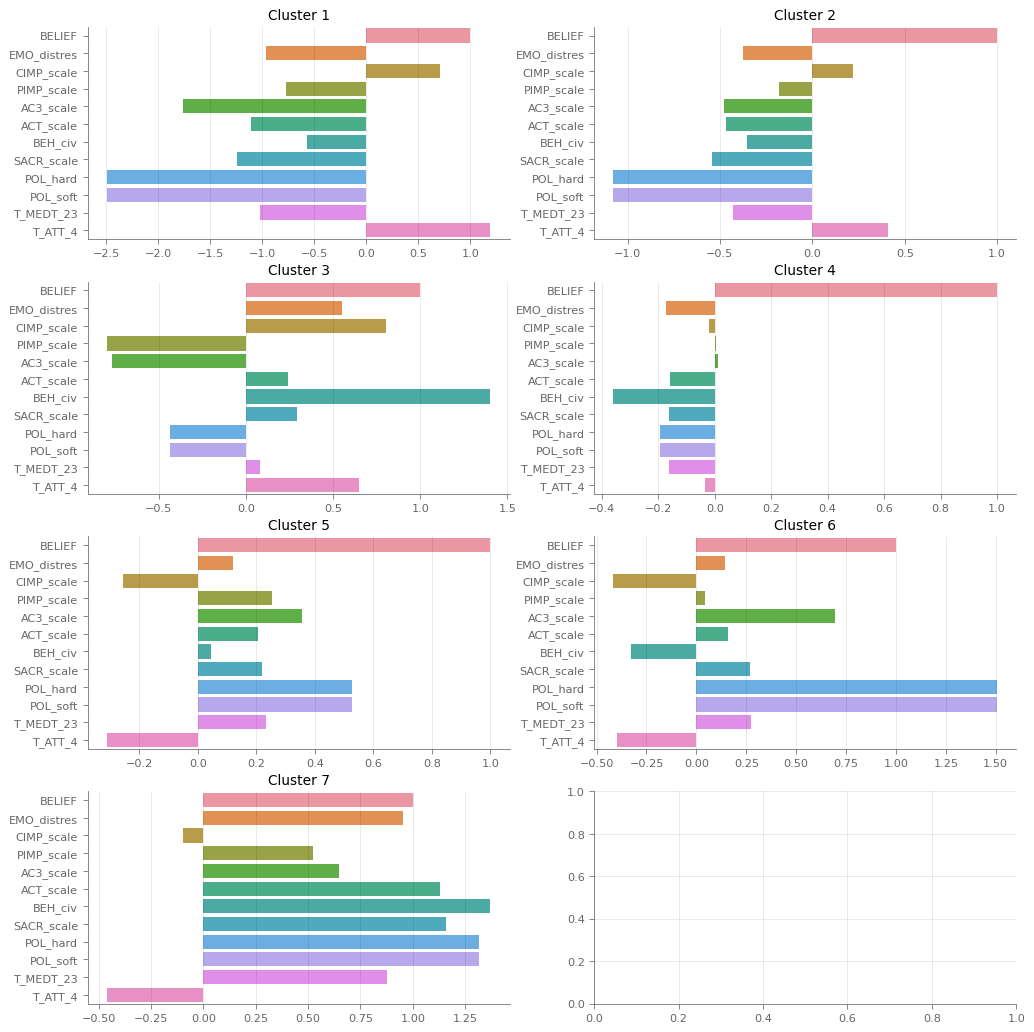

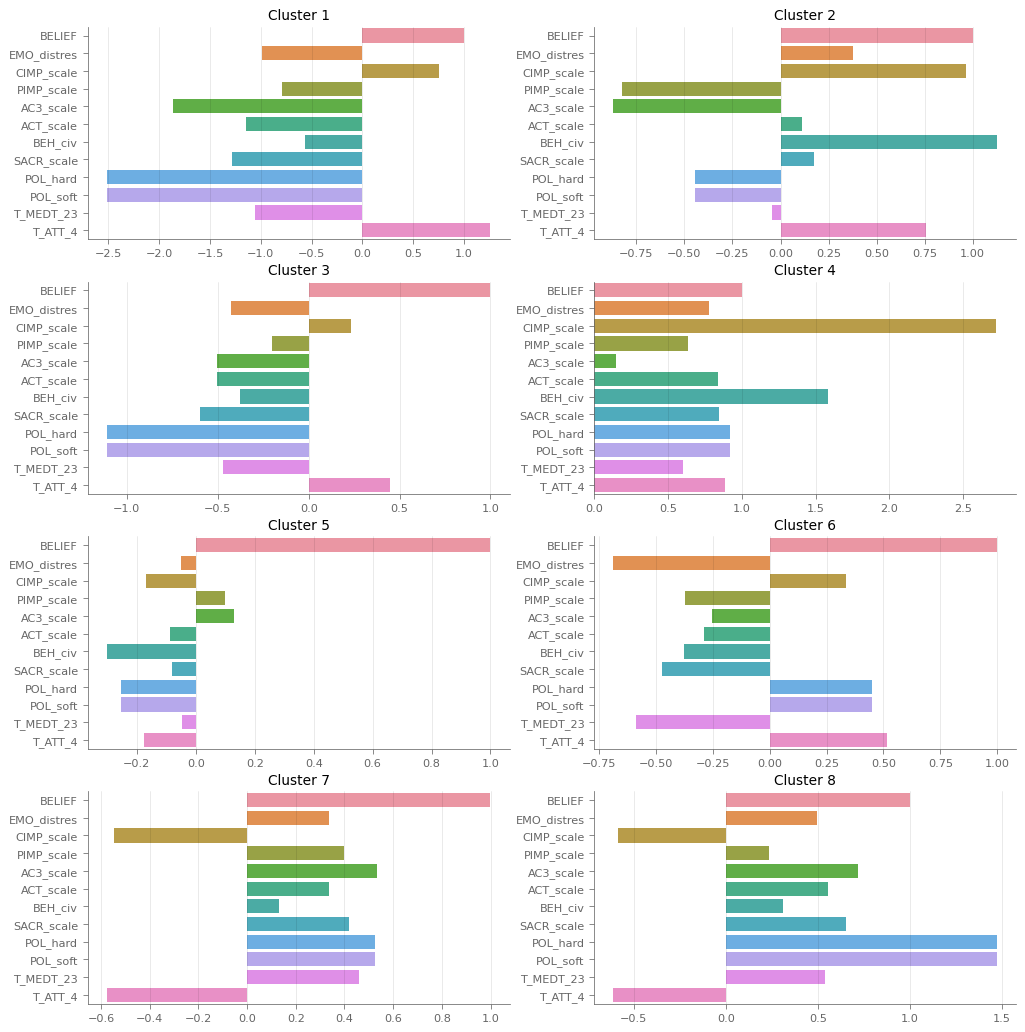

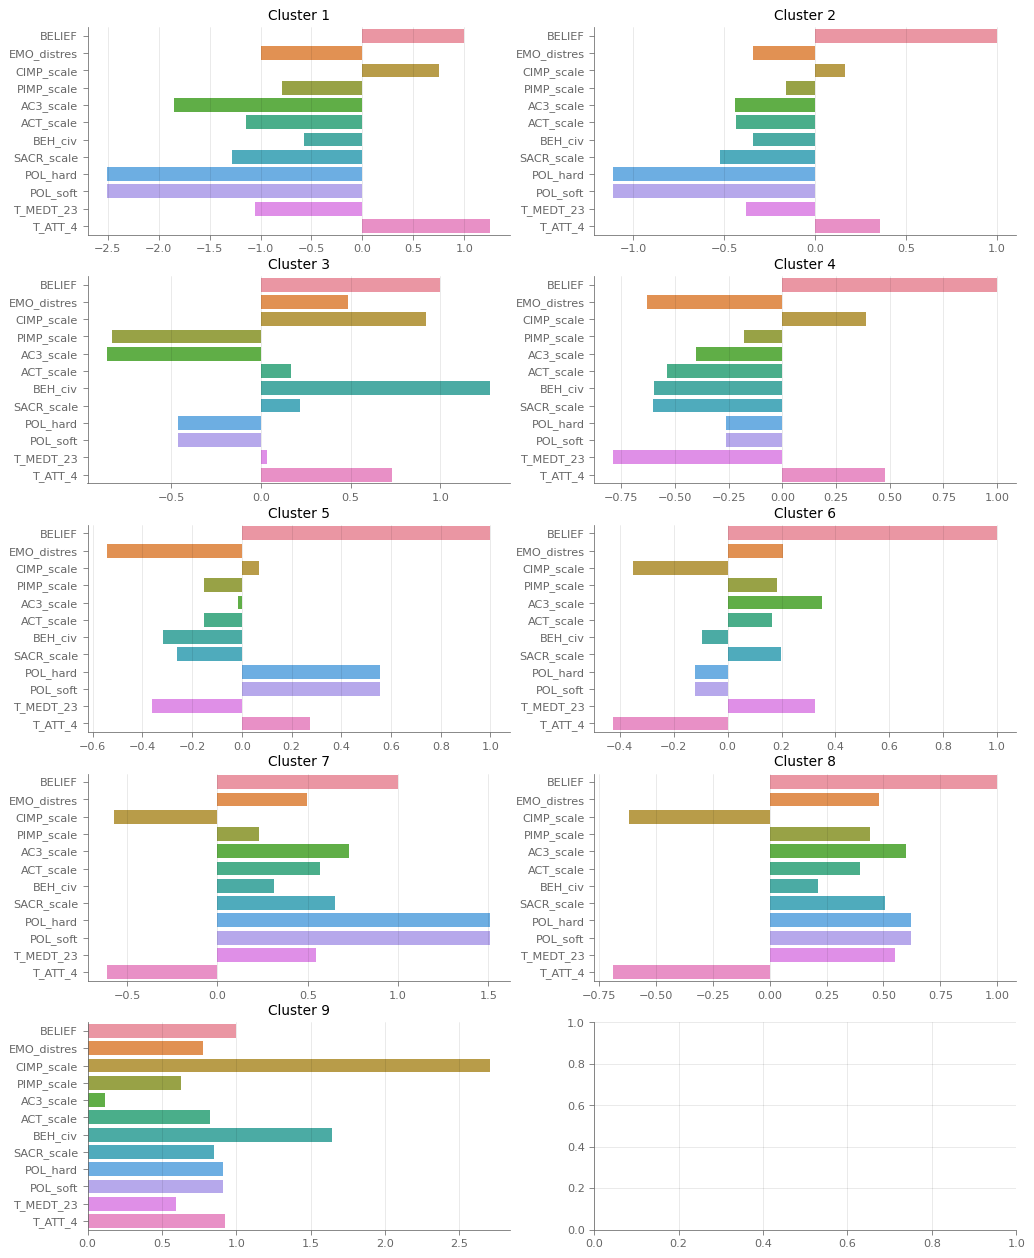

In [100]:
full_sel = []

foo = pd.DataFrame({'n': full_res['LL'].keys(), 'll': full_res['LL'].values(), 'aic': full_res['AIC'].values(), 'bic': full_res['BIC'].values()})

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, x in enumerate(['ll', 'aic', 'bic']):
    sns.barplot(data=foo, x='n', y=x, ax=ax[i])
full_sel.append(Chart(fig, title='Criteria'))

for n in range(2, 10):

    print(i)
    nrows = (n - 1) // 2 + 1
    fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
    means = full_res['mean'][n][0]

    for i in range(n):
        cur_means = means[i * 12:(i + 1) * 12]
        if n > 2:
            sns.barplot(x=cur_means, y=full_vars, ax=ax[i // 2, i % 2])
            ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
        else:
            sns.barplot(x=cur_means, y=full_vars, ax=ax[i])
            ax[i].set_title(f'Cluster {i + 1}')
    
    full_sel.append(Chart(fig, title=f'{n} clusters'))

2
1
2
3
4
5
6
7


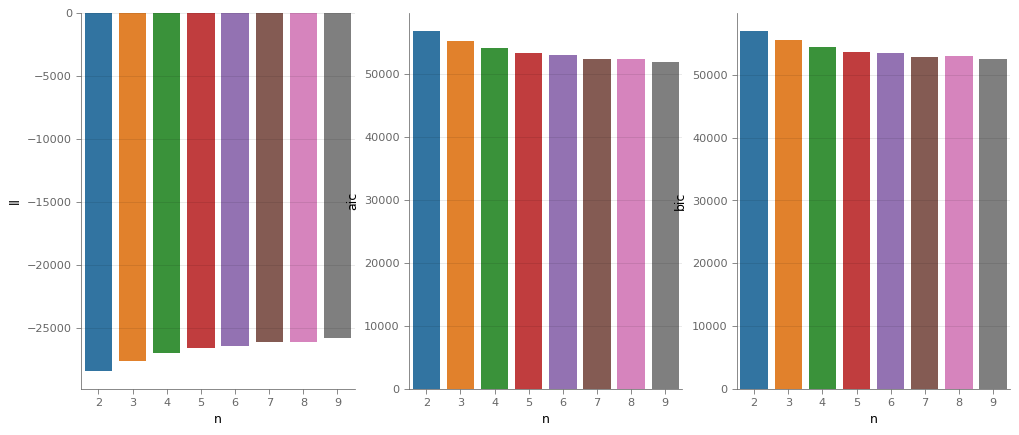

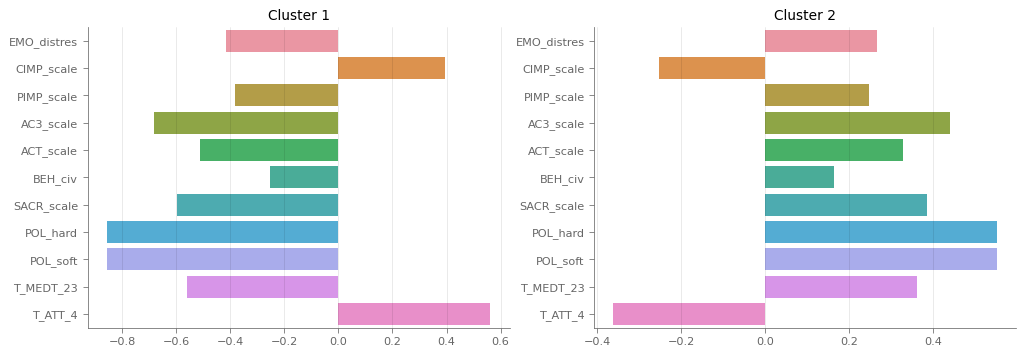

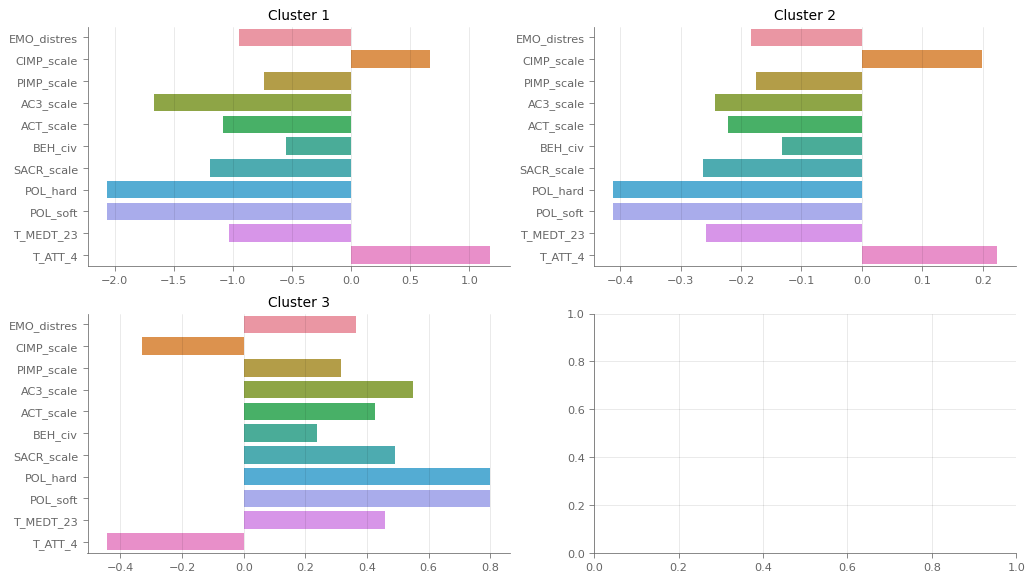

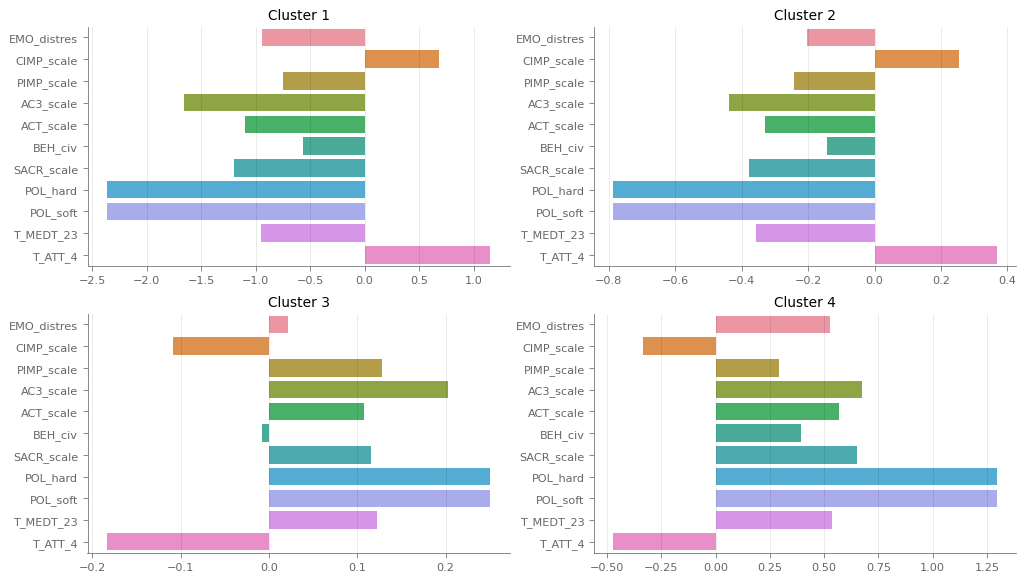

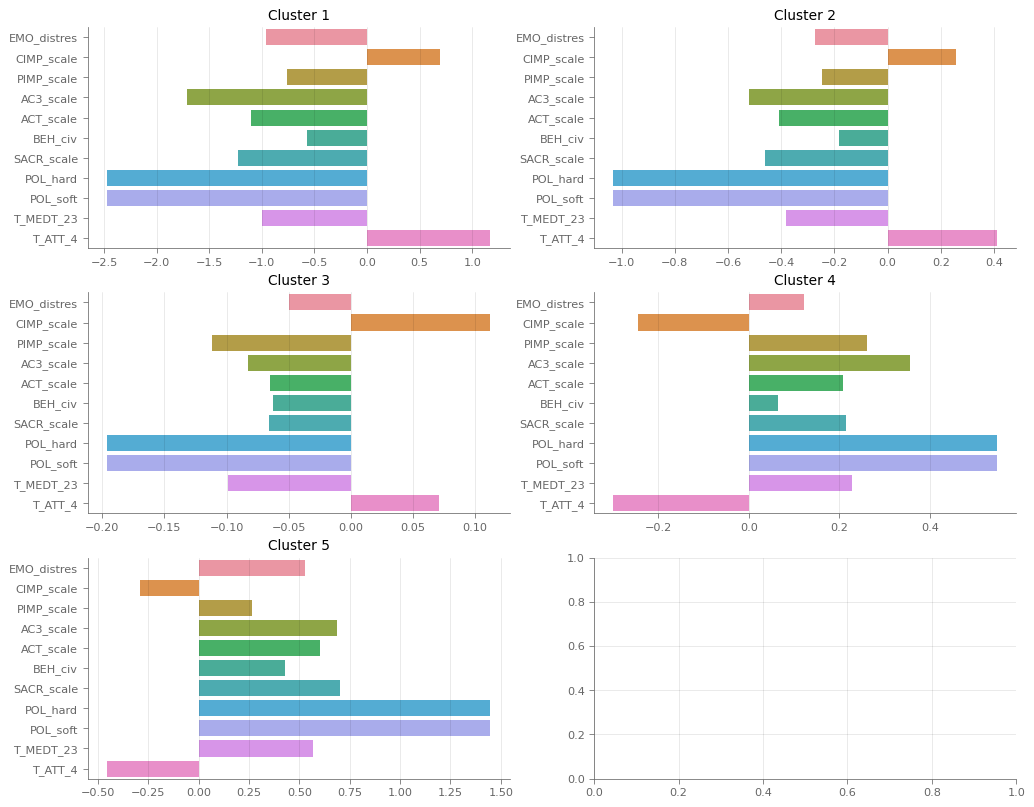

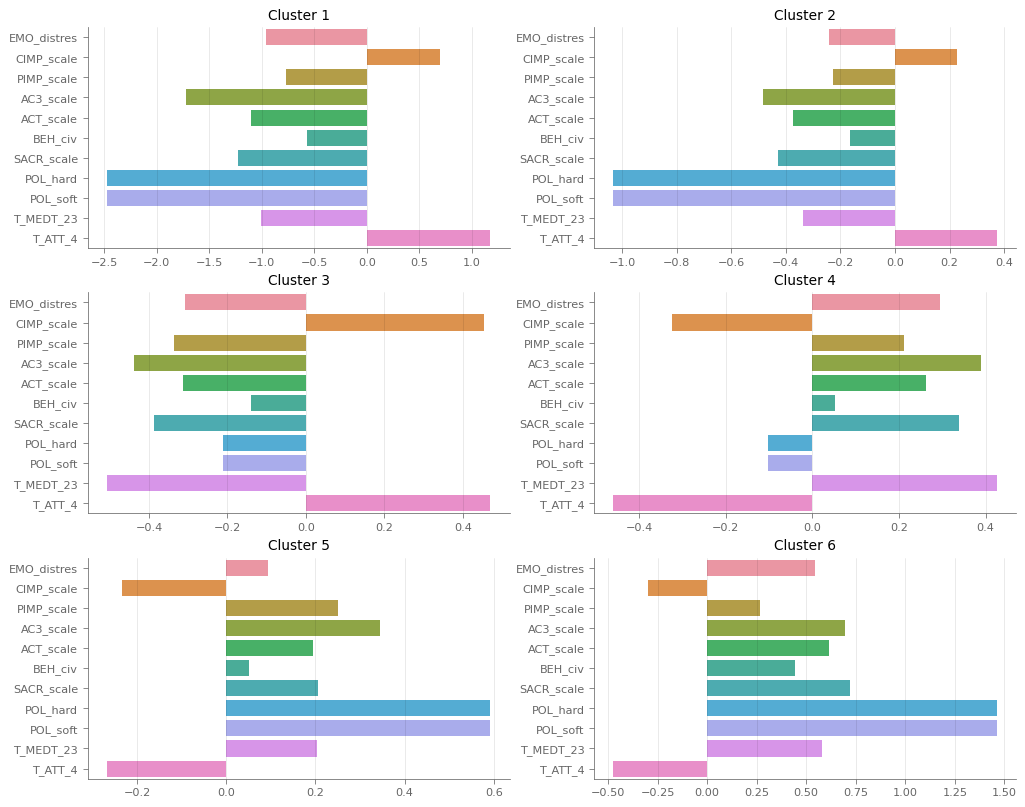

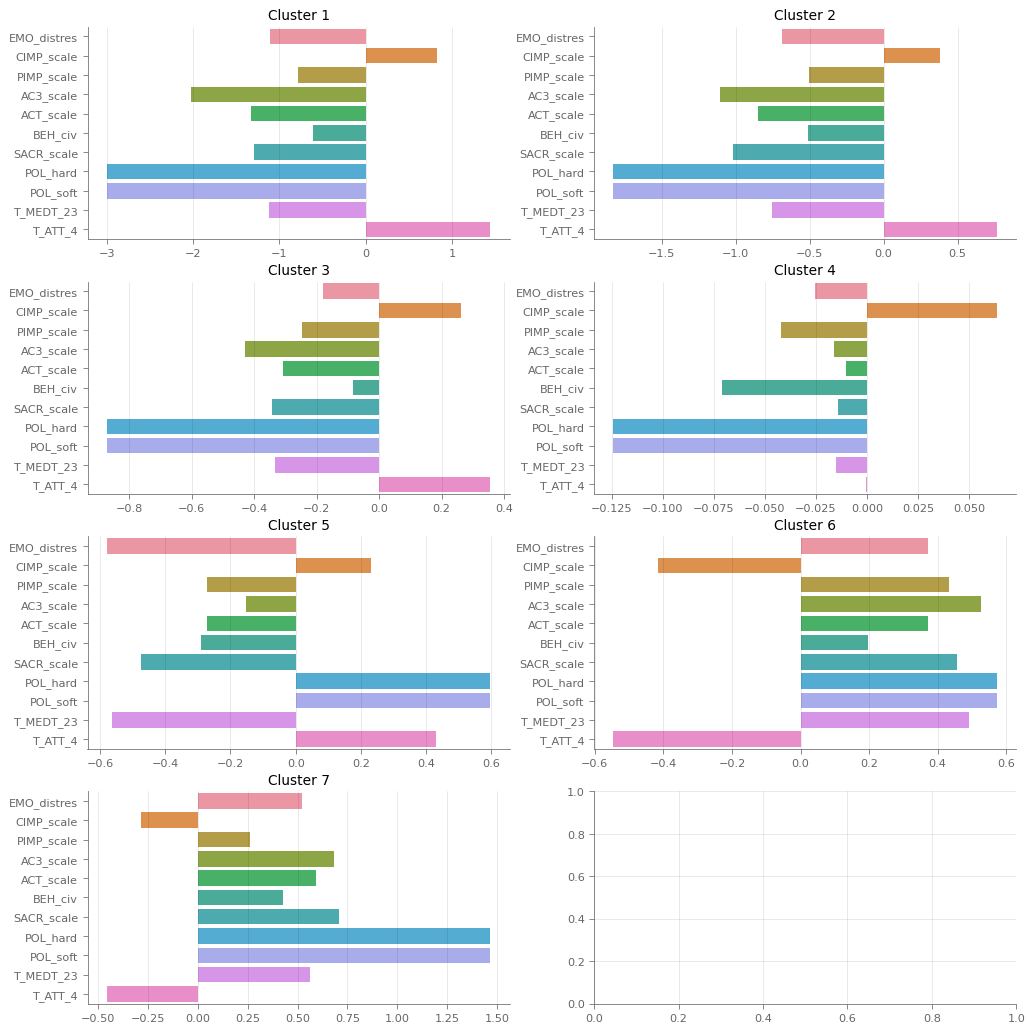

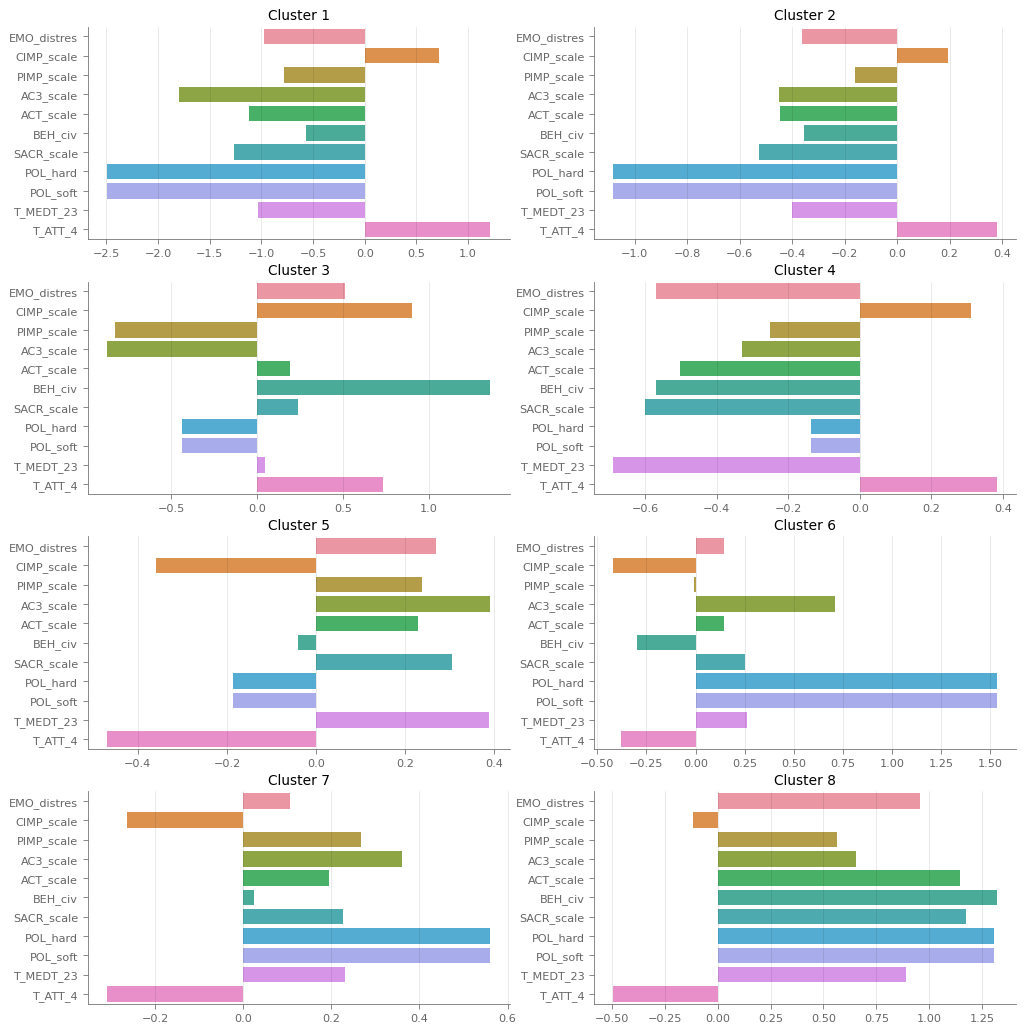

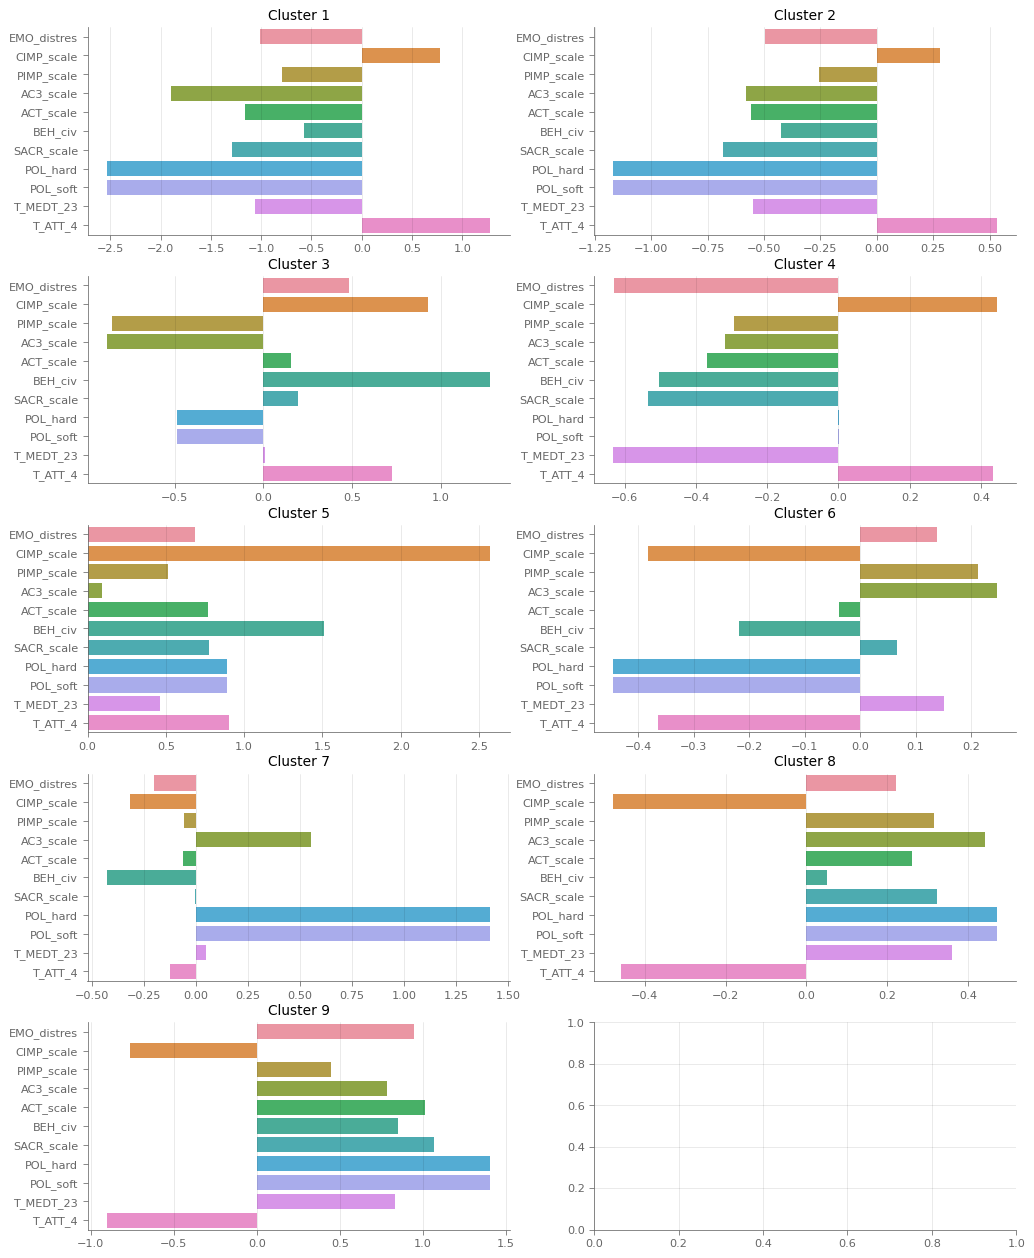

In [101]:
cont_sel = []

foo = pd.DataFrame({'n': cont_res['LL'].keys(), 'll': cont_res['LL'].values(), 'aic': cont_res['AIC'].values(), 'bic': cont_res['BIC'].values()})

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, x in enumerate(['ll', 'aic', 'bic']):
    sns.barplot(data=foo, x='n', y=x, ax=ax[i])
cont_sel.append(Chart(fig, title='Criteria'))

for n in range(2, 10):

    print(i)
    nrows = (n - 1) // 2 + 1
    fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
    means = cont_res['mean'][n][0]

    for i in range(n):
        cur_means = means[i * 11:(i + 1) * 11]
        if n > 2:
            sns.barplot(x=cur_means, y=cont_vars, ax=ax[i // 2, i % 2])
            ax[i // 2, i % 2].set_title(f'Cluster {i + 1}')
        else:
            sns.barplot(x=cur_means, y=cont_vars, ax=ax[i])
            ax[i].set_title(f'Cluster {i + 1}')
    
    cont_sel.append(Chart(fig, title=f'{n} clusters'))

In [102]:
clust_sel = Selector([Selector(full_sel, title='Full model'), Selector(cont_sel, title='Continuous only')])

In [103]:
clust_sel.save('output/lca/res01')

In [72]:
contvars

['EMO_distres',
 'CIMP_scale',
 'PIMP_scale',
 'AC3_scale',
 'ACT_scale',
 'BEH_civ',
 'SACR_scale',
 'POL_hard',
 'POL_soft']

In [73]:
ordvars

['T_MEDT_23', 'T_ATT_4']

In [60]:
sns.barplot(x=full_res['LL'].keys(), y=full_res['LL'].values())

AttributeError: 'bool' object has no attribute 'all'

In [ ]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = totwgt]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

<AxesSubplot:xlabel='BELIEF', ylabel='vaha'>

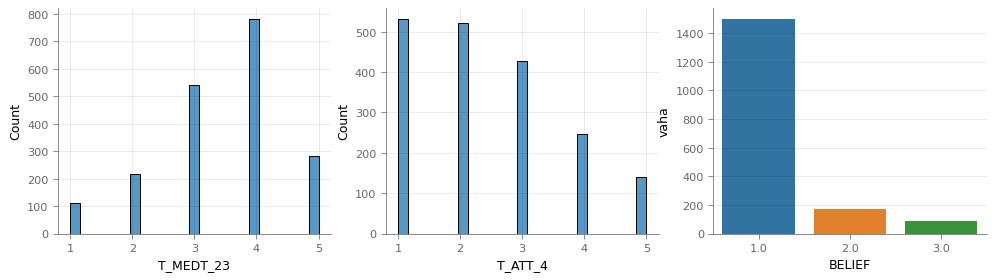

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ordvars = ['T_MEDT_23', 'T_ATT_4']

for i in range(2):
    sns.histplot(data=df, x=ordvars[i], weights='vaha', ax=ax[i], bins=25)

foo = df.groupby('BELIEF')['vaha'].sum().reset_index()
sns.barplot(data=foo, x='BELIEF', y='vaha', ax=ax[2])